In [1]:
!pip install 'aif360[LFR]'

  Using cached aif360-0.4.0-py3-none-any.whl (175 kB)
  Using cached tempeh-0.1.12-py3-none-any.whl (39 kB)
  Using cached scipy-1.5.4.tar.gz (25.2 MB)
  Installing build dependencies ... error
  ERROR: Command errored out with exit status 1:
   command: /Users/max/Desktop/Wine_equality_/temp_env/bin/python3 /private/var/folders/3v/kl4z85b17kd84k1hy0srlb3w0000gn/T/pip-standalone-pip-1hu8hhh2/__env_pip__.zip/pip install --ignore-installed --no-user --prefix /private/var/folders/3v/kl4z85b17kd84k1hy0srlb3w0000gn/T/pip-build-env-qganxv1n/overlay --no-warn-script-location --no-binary :none: --only-binary :none: -i https://pypi.org/simple -- wheel setuptools 'Cython>=0.29.18' 'numpy==1.14.5; python_version=='"'"'3.6'"'"' and platform_system!='"'"'AIX'"'"'' 'numpy==1.14.5; python_version=='"'"'3.7'"'"' and platform_system!='"'"'AIX'"'"'' 'numpy==1.17.3; python_version>='"'"'3.8'"'"' and platform_system!='"'"'AIX'"'"'' 'numpy==1.16.0; python_version=='"'"'3.6'"'"' and platform_system=='"'"'AI

In [2]:
cd /usr/local/lib/python3/dist-packages/aif360/data/raw/adult


[Errno 2] No such file or directory: '/usr/local/lib/python3/dist-packages/aif360/data/raw/adult'
/Users/max/Desktop/ML/244835


In [3]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test

--2022-07-03 12:00:59--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data.1’

adult.data.1        100%[===================>]   3.79M  2.27MB/s    in 1.7s    

2022-07-03 12:01:01 (2.27 MB/s) - ‘adult.data.1’ saved [3974305/3974305]

--2022-07-03 12:01:02--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5229 (5.1K) [application/x-httpd-php]
Saving to: ‘adult.names.1’

adult.names.1       100%[===================>]   5.11K  --.-KB/s    in 0s      


In [4]:
!pip install fairlearn

  Using cached fairlearn-0.7.0-py3-none-any.whl (177 kB)
You should consider upgrading via the '/Users/max/Desktop/Wine_equality_/temp_env/bin/python3 -m pip install --upgrade pip' command.


In [3]:

import numpy as np
from aif360.datasets import AdultDataset
from aif360.datasets import GermanDataset
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_german
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
import pdb
from sklearn.preprocessing import StandardScaler  #MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import *
from sklearn.model_selection import KFold

np.random.seed(0)

ModuleNotFoundError: No module named 'aif360'

In [151]:
from os import stat
#Utils 

def average (folds:int,adict:dict, param = 'acc'):
  """Params include evaluation metrics and fairness metrics
  evaluation metrics = 'acc'
  fairness metrics = 'stat_par_diff', 'eq_opp_diff', 'avg_odds_diff', 'bal_acc', 'disp_imp' 
  """
  values = adict.get(param)
  output = sum(values)/len(values)

  return output*100

def cross_validation_result(model,folds, train_x,train_y, train):
  """Output a dictionary of evaluation metrics and fairness metrics
  Uses a kfold object kf_x_train of (train,test)
  train_x, train_y is the scaled version of the dependent and independent variables of the train dataset
  """
  #Creating Kfolds for cross-validation 
  kf = KFold(n_splits = folds)
  kf_x = kf.split(train_x)

  #Since X_train_adult is uniform in dimension with y_train_adult
  kf_y = kf_x

  results = {}
  for i, ((a_train,a_test)) in enumerate(kf_x):

    temp_test = train_x[a_test] #training fold 
    real_test = train_y[a_test] #testing fold

    model.fit(train_x[a_train],train_y[a_train])
    predictions = model.predict(temp_test)

    train_cv= train.subset(a_test)
    train_cv_pred = train_cv.copy()
    train_cv_pred.labels = predictions

    #Obtaininig accuracy
    acc = sum(predictions==real_test)/len(real_test)
    temp_value = results.get('acc', [])
    temp_value.append(acc)
    results['acc'] = temp_value

    #obtaining average
    acc = average(folds, results, 'acc')
  print(f"The average accuracy across {folds} is {acc}")
    
  return results,acc

def cross_validation_result_w_fairness(model,folds, train_x,train_y, train):
  """Output a dictionary of evaluation metrics and fairness metrics
  Uses a kfold object kf_x_train of (train,test)
  train_x, train_y is the scaled version of the dependent and independent variables of the train dataset
  """
  #Creating Kfolds for cross-validation 
  kf = KFold(n_splits = folds)
  kf_x = kf.split(train_x)

  #Since X_train_adult is uniform in dimension with y_train_adult
  kf_y = kf_x

  results = {}
  for i, ((a_train,a_test)) in enumerate(kf_x):

    temp_test = train_x[a_test] #training fold
    real_test = train_y[a_test] #testing fold

    model.fit(train_x[a_train],train_y[a_train])
    predictions = model.predict(temp_test)

    train_cv= train.subset(a_test)
    train_cv_pred = train_cv.copy()
    train_cv_pred.labels = predictions

    #Obtaining fairness metric
    metric = ClassificationMetric(train_cv, train_cv_pred, unprivileged_groups= unprivileged_groups, privileged_groups=privileged_groups)
    metric_arrs = {}; metric_arrs['eq_opp_diff'] = [];    metric_arrs['stat_par_diff'] = []
    metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
    metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())

    results.update(metric_arrs)
    #Computing average
    eq_opp_diff = average(folds, results, 'eq_opp_diff')
    stat_par_diff = average(folds, results, 'stat_par_diff')

  print(f"The average eq_opp_diff across {folds} is {eq_opp_diff}")

  return results, eq_opp_diff, stat_par_diff

def cross_validation_result_w_reweighing(model,folds, RW, train_x,train_y,train, unprivileged_groups, privileged_groups):
  
  """Initialized Kfolds prior"""

  #Creating Kfolds for cross-validation 
  kf = KFold(n_splits = folds)
  kf_x = kf.split(train_x)

  #Since X_train_adult is uniform in dimension with y_train_adult
  kf_y = kf_x

  
  results_rw = {}

  for i, ((a_train,a_test),(b_train,b_test)) in enumerate(zip(kf_x,kf_y)):

    temp_train = train.subset(a_train) #training fold 
    temp_train_cv = train.subset(a_test) #testing fold

    n_train = RW.fit_transform(temp_train) #reweighed sampled

    model.fit(train_x[a_train],train_y[a_train],sample_weight = n_train.instance_weights)

    predictions = model.predict(train_x[a_test])

    train_cv_pred = temp_train_cv.copy()
    train_cv_pred.labels = predictions

    #Obtaining accuracy
    actual = train_y[a_test]
    acc_rw = sum(actual == predictions)/len(predictions)

    temp_value = results_rw.get('acc', [])
    temp_value.append(acc_rw)
    results_rw['acc'] = temp_value

    #Obtaining metrics
    metric = ClassificationMetric(temp_train_cv, train_cv_pred, unprivileged_groups= unprivileged_groups, privileged_groups=privileged_groups)
    
    metric_arrs = {}; metric_arrs['stat_par_diff'] = [] ; metric_arrs['eq_opp_diff'] = []
    metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
    metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
    results_rw.update(metric_arrs)

    #Computing average across folds 
    acc = average(folds, results_rw, 'acc')
    eq_opp_diff = average(folds, results_rw, 'eq_opp_diff')
    stat_par_diff = average(folds, results_rw, 'stat_par_diff')

    print(f"The average accuracy across {folds} is {acc},The average eq_opp_diff across {folds} is {eq_opp_diff}")
  return results_rw,acc,eq_opp_diff,stat_par_diff


In [164]:
#LOADING DATASET

#Adult Dataset
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

dataset_adult = load_preproc_data_adult(['sex'])
train_adult, test_adult = dataset_adult.split([0.7], shuffle=True)
print("Adult training data size", train_adult.features.shape)
print("Adult dataset feature names", train_adult.feature_names)


Adult training data size (34189, 18)
Adult dataset feature names ['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']


ADULT DATASET

In [153]:
#Normalize the dataset, both train and test
scale_orig = StandardScaler()

X_train_adult = scale_orig.fit_transform(train_adult.features)
y_train_adult = train_adult.labels.ravel()

X_test_adult = scale_orig.fit_transform(test_adult.features)
y_test_adult = test_adult.labels.ravel()

In [ ]:
from xgboost import XGBClassifier

#default xgb boost parameters as baseline model

xgb = XGBClassifier()

In [ ]:
xgb_result,avg = cross_validation_result(xgb, 5, X_train_adult,y_train_adult, train_adult)
avg

The average accuracy across 5 is 80.34748174204644


80.34748174204644

Vary hyperparameters

The average accuracy across 5 is 80.34748174204644
The average accuracy across 5 is 80.3708808244184
The average accuracy across 5 is 80.2743613742868
The average accuracy across 5 is 80.28021103793114


Text(0.5, 1.0, 'Accuracy vs depth')

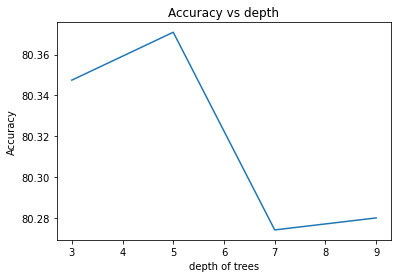

In [ ]:
#Vary learning_rate, vary max_depth and also vary scale_pos_weight
import matplotlib.pyplot as plt

depth = [3,5,7,9]; accuracy_w_depth = []

for d in depth:
  xgb_temp  = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, 
       
       max_depth= d ,
       
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
  
  _,temp_avg = cross_validation_result(xgb_temp, 5, X_train_adult,y_train_adult, train_adult)
  accuracy_w_depth.append(temp_avg)

plt.plot(depth,accuracy_w_depth)

plt.ylabel("Accuracy")
plt.xlabel("depth of trees")
plt.title("Accuracy vs depth")

The average accuracy across 5 is 80.33285758293559
The average accuracy across 5 is 80.33578241475774
The average accuracy across 5 is 80.35918149712973
The average accuracy across 5 is 80.3708808244184
The average accuracy across 5 is 80.30068486068632
The average accuracy across 5 is 80.26558687882029
The average accuracy across 5 is 80.26851171064244


Text(0.5, 1.0, 'Accuracy vs learning rate')

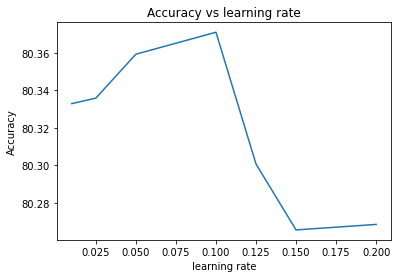

In [ ]:
#Selecting max_depth as 5 with high accuracy, now varying learning rate 

learning_rate = [0.01,0.025,0.05,0.1,0.125,0.15,0.2]
accuracy_w_learning_rate = []

for l in learning_rate:
  xgb_temp  = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0,

      learning_rate= l, 

       max_delta_step=0, max_depth= 5 ,min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
  
  _,temp_avg = cross_validation_result(xgb_temp, 5, X_train_adult,y_train_adult, train_adult)
  accuracy_w_learning_rate.append(temp_avg)

plt.plot(learning_rate,accuracy_w_learning_rate)

plt.ylabel("Accuracy")
plt.xlabel("learning rate")
plt.title("Accuracy vs learning rate")

The average accuracy across 5 is 80.3708808244184
The average accuracy across 5 is 80.3708808244184
The average accuracy across 5 is 80.37380565624058
The average accuracy across 5 is 79.58992377683785


Text(0.5, 1.0, 'Accuracy vs Scale_pos_weight')

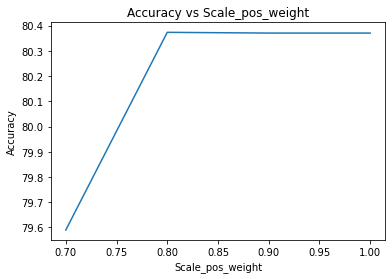

In [ ]:
#Selecting learning rate as 0.1, now varying the scale_pos_weight

accuracy_w_scale_pos_weight = []
scale_pos = [1,0.9,0.8,0.7]

for s in scale_pos:
  xgb_temp  = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0,learning_rate= 0.1, max_delta_step=0, max_depth= 5 ,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,

       scale_pos_weight= s, 
       
       seed=0, silent=True, subsample=1)
  
  _,temp_avg = cross_validation_result(xgb_temp, 5, X_train_adult,y_train_adult, train_adult)
  accuracy_w_scale_pos_weight.append(temp_avg)

plt.plot(scale_pos,accuracy_w_scale_pos_weight)

plt.ylabel("Accuracy")
plt.xlabel("Scale_pos_weight")
plt.title("Accuracy vs Scale_pos_weight")

The average accuracy across 5 is 80.37380565624058
The average accuracy across 5 is 80.36503116077407
The average accuracy across 5 is 80.35040700166321
The average accuracy across 5 is 80.35918149712973
The average accuracy across 5 is 80.34748216984106


Text(0.5, 1.0, 'Accuracy vs Base_score')

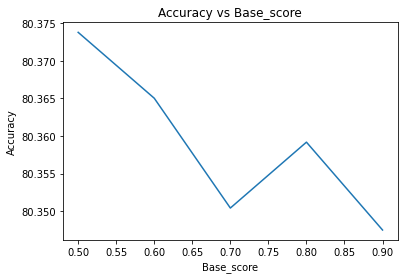

In [ ]:
#Accuracy seemed to stabilise at 0.80, now varying the base score 

accuracy_w_base_score = []
base_score = [0.5,0.6,0.7,0.8,0.9]

for b in base_score:
  xgb_temp  = XGBClassifier(base_score= b, 
                            colsample_bylevel=1, colsample_bytree=1,
       gamma=0,learning_rate= 0.1, max_delta_step=0, max_depth= 5 ,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight= 0.8 , seed=0, silent=True, subsample=1)
  
  _,temp_avg = cross_validation_result(xgb_temp, 5, X_train_adult,y_train_adult, train_adult)
  accuracy_w_base_score.append(temp_avg)

plt.plot(base_score,accuracy_w_base_score)

plt.ylabel("Accuracy")
plt.xlabel("Base_score")
plt.title("Accuracy vs Base_score")

Varying L1 regularization and L2 regularization

The average accuracy across 5 is 80.35625666530755
The average accuracy across 5 is 80.3416325061967
The average accuracy across 5 is 80.37965531988492
The average accuracy across 5 is 80.3650311607741
The average accuracy across 5 is 80.36795599259622
The average accuracy across 5 is 80.3533318334854
The average accuracy across 5 is 80.35918149712973
The average accuracy across 5 is 80.37380565624058
The average accuracy across 5 is 80.36210632895191
The average accuracy across 5 is 80.38842981535143
The average accuracy across 5 is 80.3650311607741
The average accuracy across 5 is 80.36503116077407
The average accuracy across 5 is 80.36210632895191
The average accuracy across 5 is 80.37380565624058
The average accuracy across 5 is 80.36795599259625
The average accuracy across 5 is 80.37380565624058
The average accuracy across 5 is 80.37380565624058
The average accuracy across 5 is 80.37380565624058
The average accuracy across 5 is 80.37380565624058
The average accuracy across 5 is 80

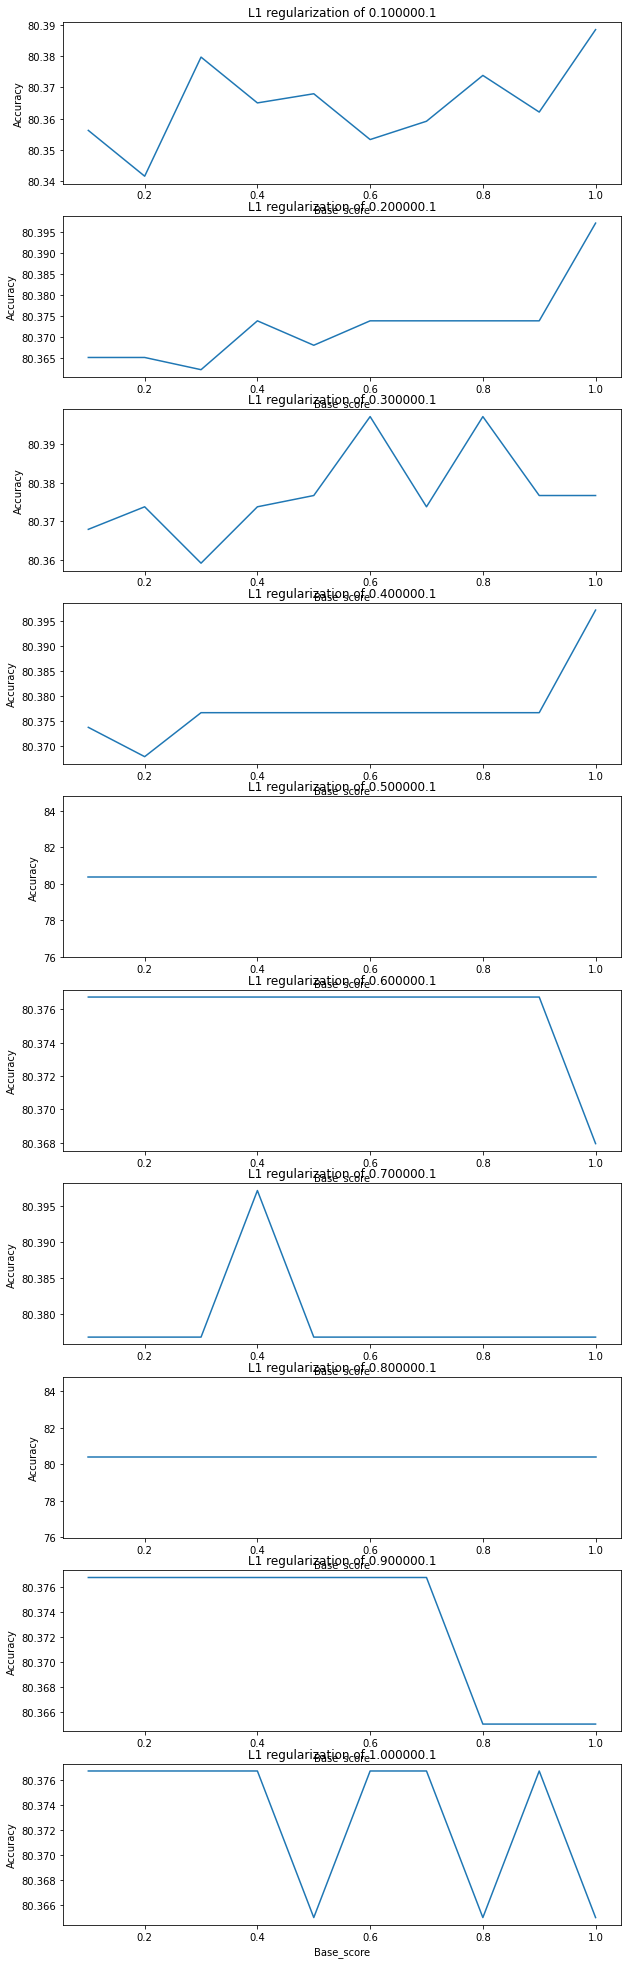

In [ ]:
#Base score dipped considerably from a value of 0.5, now varying the l1 and l2 regularization

reg_alpha_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
reg_lambda_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

fig, ax = plt.subplots(nrows = len(reg_alpha_range), ncols = 1, figsize = (10,35))

for i,c in enumerate(reg_alpha_range):
  accuracy_w_reg = []
  for j,d in enumerate(reg_lambda_range):
    xgb_temp  = XGBClassifier(base_score= 0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0,learning_rate= 0.1, max_delta_step=0, max_depth= 5 ,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', 
       reg_alpha=c, reg_lambda=d,
       scale_pos_weight= 0.8 , seed=0, silent=True, subsample=1)
  
    _,temp_avg, = cross_validation_result(xgb_temp, 5, X_train_adult,y_train_adult, train_adult)
    accuracy_w_reg.append(temp_avg)

  ax[i].plot(reg_lambda_range,accuracy_w_reg)
  ax[i].set_ylabel("Accuracy")
  ax[i].set_xlabel("Base_score")
  ax[i].set_title(f"L1 regularization of %5f.1"%c)
plt.show()

Assessing Model on Test data

In [ ]:
#Using RandomSearchCV and #GridSearchCV as opposed to varying hyperparameters manually

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

model = XGBClassifier()

params = {"base_score" :[0.1,0.2,0.3,0.4,0.5],
    "learning_rate": [0.1,0.2,0.3,0.4,0.5],"max_depth" : [3,5,7,9],
    "n_estimators": [100], "reg_alpha": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9], 
    "reg_lambda": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],
    "scale_pos_weight":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]}

grid_CV = GridSearchCV(model, params, n_jobs = 10)
grid_CV.fit(X_train_adult,y_train_adult)

predictions = model(**grid_CV.best_params_).predict(X_test_adult)
test_acc = sum(predictions==y_test_adult)/len(y_test_adult)

In [169]:
#Highest accuracy was recorded with an L1 regularisation of 0.4, and L2 regularisation of 1.0

model_1 = XGBClassifier(base_score= 0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0,learning_rate= 0.1, max_delta_step=0, max_depth= 5 ,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', 
       reg_alpha=0.4, reg_lambda=1.0,
       scale_pos_weight= 0.8 , seed=0, silent=True, subsample=1)
  
model_1.fit(X_train_adult, y_train_adult)
predictions = model_1.predict(X_test_adult)

test_adult_pred = test_adult.copy()
test_adult_pred.labels = predictions 

#Obtaining accuracy
test_acc = sum(predictions==y_test_adult)/len(y_test_adult)

#obtaining fairness metric
metric = ClassificationMetric(test_adult, test_adult_pred, unprivileged_groups= unprivileged_groups, privileged_groups=privileged_groups)
eq_opp_diff_test = metric.equal_opportunity_difference()

(eq_opp_diff_test,test_acc)

(0.02433482629221642, 0.8038626902340817)

ASSESSING FAIRNESS METRICS

The average eq_opp_diff across 5 is -45.20255863539446
The average eq_opp_diff across 5 is -45.20255863539446
The average eq_opp_diff across 5 is -45.20255863539446
The average eq_opp_diff across 5 is -45.91329068941009
The average eq_opp_diff across 5 is -45.91329068941009
The average eq_opp_diff across 5 is -45.98436389481166
The average eq_opp_diff across 5 is -45.91329068941009


Text(0.5, 1.0, 'Equal opportunity difference vs Learning rate')

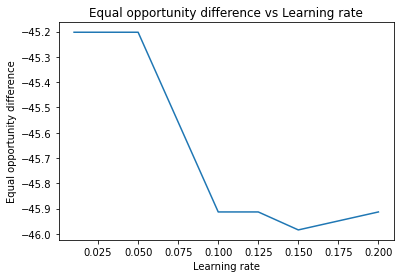

In [ ]:
#Starting with a max-depth of 5 and base score of 0.5

learning_rate = [0.01,0.025,0.05,0.1,0.125,0.15,0.2]
eq_opp_diff_w_learning_rate = [] 

for l in learning_rate:
  xgb_temp  = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, 
       learning_rate= l, 
       max_delta_step=0, max_depth= 5,min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=0.8, seed=0, silent=True, subsample=1)
  
  _,temp_eq_opp_diff,_ = cross_validation_result_w_fairness(xgb_temp, 5, X_train_adult,y_train_adult, train_adult) 
  eq_opp_diff_w_learning_rate.append(temp_eq_opp_diff)

plt.plot(learning_rate, eq_opp_diff_w_learning_rate)
plt.ylabel("Equal opportunity difference")
plt.xlabel("Learning rate")
plt.title("Equal opportunity difference vs Learning rate")


The average eq_opp_diff across 5 is -45.20255863539446
The average eq_opp_diff across 5 is -45.20255863539446
The average eq_opp_diff across 5 is -45.20255863539446
The average eq_opp_diff across 5 is -45.20255863539446
The average eq_opp_diff across 5 is -45.20255863539446
The average eq_opp_diff across 5 is -45.20255863539446
The average eq_opp_diff across 5 is -45.20255863539446
The average eq_opp_diff across 5 is -45.20255863539446
The average eq_opp_diff across 5 is -45.20255863539446
The average eq_opp_diff across 5 is -45.20255863539446
The average eq_opp_diff across 5 is -45.20255863539446
The average eq_opp_diff across 5 is -45.20255863539446
The average eq_opp_diff across 5 is -45.20255863539446
The average eq_opp_diff across 5 is -45.20255863539446
The average eq_opp_diff across 5 is -45.20255863539446
The average eq_opp_diff across 5 is -45.20255863539446
The average eq_opp_diff across 5 is -45.20255863539446
The average eq_opp_diff across 5 is -45.20255863539446
The averag

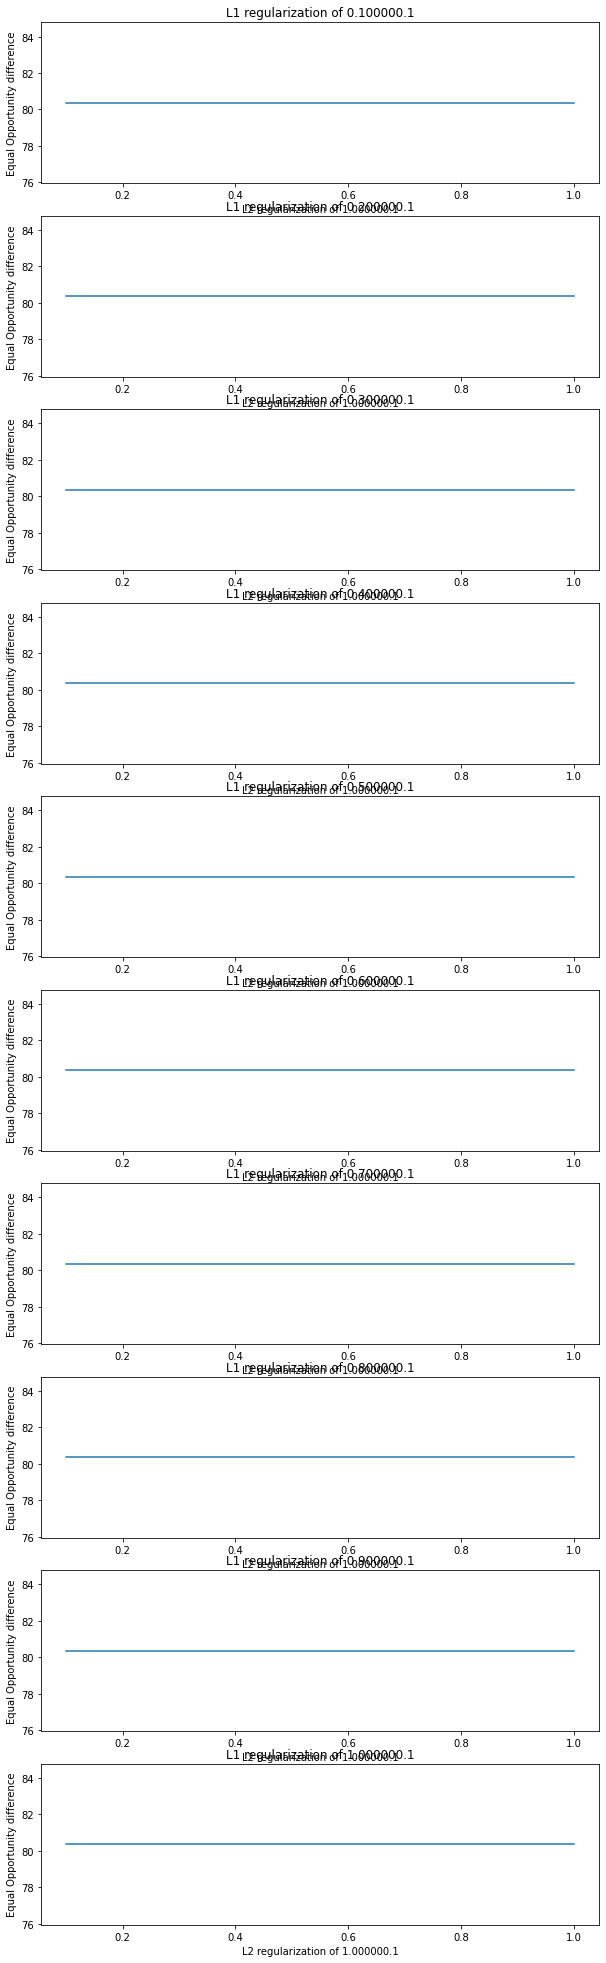

In [ ]:
#Lowest equality of opportunity difference at learning rate of 0.05
#Varying l1 and l2 regularisation

reg_alpha_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
reg_lambda_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

fig, ax = plt.subplots(nrows = len(reg_alpha_range), ncols = 1, figsize = (10,35))

for i,c in enumerate(reg_alpha_range):
  eq_opp_w_reg = []
  for j,d in enumerate(reg_lambda_range):
    xgb_temp  = XGBClassifier(base_score= 0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0,learning_rate= 0.05, max_delta_step=0, max_depth= 5 ,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', 
       reg_alpha=c, reg_lambda=d,
       scale_pos_weight= 0.8 , seed=0, silent=True, subsample=1)
  
    _,temp_eq_opp_reg,_ = cross_validation_result_w_fairness(xgb_temp, 5, X_train_adult,y_train_adult, train_adult)
    eq_opp_w_reg.append(temp_avg)

  ax[i].plot(reg_lambda_range,eq_opp_w_reg)
  ax[i].set_ylabel("Equal Opportunity difference")
  ax[i].set_xlabel("L2 regularization of %1f.1"%d)
  ax[i].set_title(f"L1 regularization of %1f.1"%c)

Assessing Model on Test Data

Model 2

In [168]:
#equal opportunity does not change with l1 and l2 regularisation
Model_2 = XGBClassifier(base_score= 0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0,learning_rate= 0.05, max_delta_step=0, max_depth= 5 ,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', 

       reg_alpha=0, reg_lambda=1.0,

       scale_pos_weight= 0.8 , seed=0, silent=True, subsample=1)
  
Model_2.fit(X_train_adult, y_train_adult)
predictions = Model_2.predict(X_test_adult)

test_adult_pred = test_adult.copy()
test_adult_pred.labels = predictions 

#Obtaining accuracy
test_acc_fairness = sum(predictions==y_test_adult)/len(y_test_adult)

#Obtaining eq_opp_diff
metric = ClassificationMetric(test_adult, test_adult_pred, unprivileged_groups= unprivileged_groups, privileged_groups=privileged_groups)
eq_opp_diff_test = metric.equal_opportunity_difference()

eq_opp_diff_test,test_acc_fairness

(0.022209175644595097, 0.8046816351600354)

IMPLEMENTING REWEIGHING 

In [ ]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

xgb_rw = XGBClassifier(base_score= 0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0,learning_rate= 0.1, max_delta_step=0, max_depth= 5 ,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', 

       reg_alpha=0, reg_lambda=1.0,
       scale_pos_weight= 1 , seed=0, silent=True, subsample=1)

#Baseline for reweighing model
_,acc_rw,eq_opp_diff_rw,stat_parr_diff = cross_validation_result_w_reweighing(xgb_rw, 5, RW, X_train_adult, y_train_adult,train_adult,unprivileged_groups= unprivileged_groups, privileged_groups = privileged_groups)
acc_rw,eq_opp_diff_rw,stat_parr_diff

The average accuracy across 5 is 78.89733840304183,The average eq_opp_diff across 5 is -5.925982285282516
The average accuracy across 5 is 78.94121088037438,The average eq_opp_diff across 5 is 13.578026251823044


(78.94121088037438, 13.578026251823044, -0.9965683901162842)

Varying hyperparameters

i) Accuracy

The average accuracy across 5 is 78.78034513015501,The average eq_opp_diff across 5 is -3.037895642683236
The average accuracy across 5 is 79.2921906990348,The average eq_opp_diff across 5 is 2.9970831307729706
The average accuracy across 5 is 78.79496928926586,The average eq_opp_diff across 5 is -3.037895642683236
The average accuracy across 5 is 79.29950277859024,The average eq_opp_diff across 5 is 2.9970831307729706
The average accuracy across 5 is 78.82421760748757,The average eq_opp_diff across 5 is -4.120928133657964
The average accuracy across 5 is 78.83152968704299,The average eq_opp_diff across 5 is 16.379436071949442
The average accuracy across 5 is 78.89733840304183,The average eq_opp_diff across 5 is -5.925982285282516
The average accuracy across 5 is 78.94121088037438,The average eq_opp_diff across 5 is 13.578026251823044
The average accuracy across 5 is 78.91196256215267,The average eq_opp_diff across 5 is -9.1750797582067
The average accuracy across 5 is 78.9631471190406

Text(0.5, 1.0, 'Reweighing: Accuracy vs learning rate')

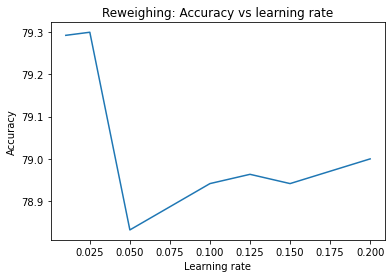

In [ ]:
learning_rate_l = [0.01,0.025,0.05,0.1,0.125,0.15,0.2]
acc_rw_learning_rate = []; eq_opp_diff_rw_learning_rate = []

for l in learning_rate_l:  
  xgb_temp = XGBClassifier(base_score= 0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0,

       learning_rate= l, 

       max_delta_step=0, max_depth= 5 ,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1.0,

       scale_pos_weight= 1 , seed=0, silent=True, subsample=1)
  
  _,temp_acc_rw,_,_ = cross_validation_result_w_reweighing(xgb_temp, 5, RW, X_train_adult, y_train_adult,train_adult,unprivileged_groups= unprivileged_groups, privileged_groups = privileged_groups)
  acc_rw_learning_rate.append(temp_acc_rw)


plt.plot(learning_rate_l,acc_rw_learning_rate)
plt.ylabel("Accuracy")
plt.xlabel("Learning rate")
plt.title("Reweighing: Accuracy vs learning rate")

The average accuracy across 5 is 78.78034513015501,The average eq_opp_diff across 5 is -3.037895642683236
The average accuracy across 5 is 79.2921906990348,The average eq_opp_diff across 5 is 2.9970831307729706
The average accuracy across 5 is 78.79496928926586,The average eq_opp_diff across 5 is -3.037895642683236
The average accuracy across 5 is 79.29950277859024,The average eq_opp_diff across 5 is 2.9970831307729706
The average accuracy across 5 is 78.82421760748757,The average eq_opp_diff across 5 is -4.120928133657964
The average accuracy across 5 is 78.83152968704299,The average eq_opp_diff across 5 is 16.379436071949442
The average accuracy across 5 is 78.89733840304183,The average eq_opp_diff across 5 is -5.925982285282516
The average accuracy across 5 is 78.94121088037438,The average eq_opp_diff across 5 is 13.578026251823044
The average accuracy across 5 is 78.91196256215267,The average eq_opp_diff across 5 is -9.1750797582067
The average accuracy across 5 is 78.9631471190406

Text(0.5, 1.0, 'Reweighing: Equal Opportunity difference vs learning rate')

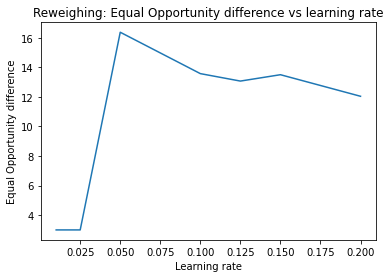

In [ ]:
learning_rate_l = [0.01,0.025,0.05,0.1,0.125,0.15,0.2]
eq_opp_diff_rw_learning_rate = []

for l in learning_rate_l:  
  xgb_temp = XGBClassifier(base_score= 0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0,

       learning_rate= l, 

       max_delta_step=0, max_depth= 5 ,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1.0,

       scale_pos_weight= 1 , seed=0, silent=True, subsample=1)
  
  _,_,temp_eq_opp_diff_rw,_ = cross_validation_result_w_reweighing(xgb_temp, 5, RW, X_train_adult, y_train_adult,train_adult,unprivileged_groups= unprivileged_groups, privileged_groups = privileged_groups)
  eq_opp_diff_rw_learning_rate.append(temp_eq_opp_diff_rw)


plt.plot(learning_rate_l,eq_opp_diff_rw_learning_rate)
plt.ylabel("Equal Opportunity difference")
plt.xlabel("Learning rate")
plt.title("Reweighing: Equal Opportunity difference vs learning rate")

The average accuracy across 5 is 78.79496928926586,The average eq_opp_diff across 5 is -3.037895642683236
The average accuracy across 5 is 79.29950277859024,The average eq_opp_diff across 5 is 2.9970831307729706
The average accuracy across 5 is 78.79496928926586,The average eq_opp_diff across 5 is -3.037895642683236
The average accuracy across 5 is 79.29950277859024,The average eq_opp_diff across 5 is 2.9970831307729706
The average accuracy across 5 is 78.79496928926586,The average eq_opp_diff across 5 is -3.037895642683236
The average accuracy across 5 is 79.29950277859024,The average eq_opp_diff across 5 is 2.9970831307729706
The average accuracy across 5 is 78.79496928926586,The average eq_opp_diff across 5 is -3.037895642683236
The average accuracy across 5 is 79.29950277859024,The average eq_opp_diff across 5 is 2.9970831307729706
The average accuracy across 5 is 78.79496928926586,The average eq_opp_diff across 5 is -3.037895642683236
The average accuracy across 5 is 79.2995027785

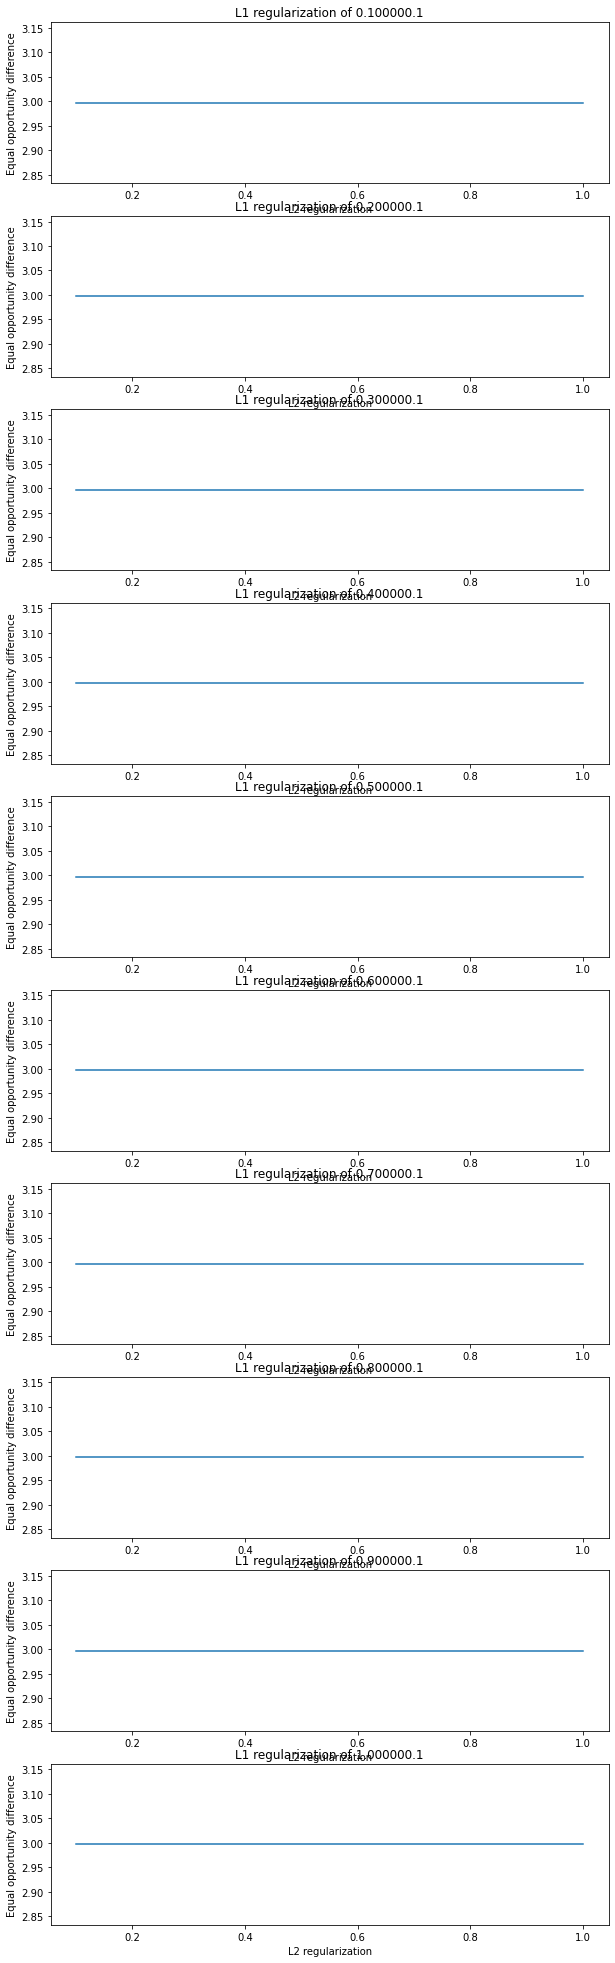

In [154]:
reg_alpha_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
reg_lambda_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

fig, ax = plt.subplots(nrows = len(reg_alpha_range), ncols = 1, figsize = (10,35))

for i,c in enumerate(reg_alpha_range):
  eq_opp_diff_w_reg = []
  for j,d in enumerate(reg_lambda_range):
    xgb_temp  = XGBClassifier(base_score= 0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0,learning_rate= 0.025, max_delta_step=0, max_depth= 5 ,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', 
       reg_alpha=c, reg_lambda=d,
       scale_pos_weight= 1 , seed=0, silent=True, subsample=1)
  
    _,_,temp_eq_opp_diff_rw,_ = cross_validation_result_w_reweighing(xgb_temp, 5, RW, X_train_adult, y_train_adult,train_adult,unprivileged_groups= unprivileged_groups, privileged_groups = privileged_groups)
    eq_opp_diff_w_reg.append(temp_eq_opp_diff_rw)


  ax[i].plot(reg_lambda_range,eq_opp_diff_w_reg)
  ax[i].set_ylabel("Equal opportunity difference")
  ax[i].set_xlabel("L2 regularization")
  ax[i].set_title(f"L1 regularization of %5f.1"%c)
plt.show()

The average accuracy across 5 is 78.91196256215267,The average eq_opp_diff across 5 is -9.1750797582067
The average accuracy across 5 is 78.9485229599298,The average eq_opp_diff across 5 is 13.578026251823044
The average accuracy across 5 is 78.91196256215267,The average eq_opp_diff across 5 is -9.1750797582067
The average accuracy across 5 is 79.43112021058789,The average eq_opp_diff across 5 is 0.19567331064657134
The average accuracy across 5 is 78.91196256215267,The average eq_opp_diff across 5 is -9.1750797582067
The average accuracy across 5 is 78.97777127815151,The average eq_opp_diff across 5 is 12.338356830335446
The average accuracy across 5 is 78.88271424393098,The average eq_opp_diff across 5 is -8.092047267231973
The average accuracy across 5 is 78.93389880081895,The average eq_opp_diff across 5 is 13.578026251823044
The average accuracy across 5 is 78.91196256215267,The average eq_opp_diff across 5 is -9.1750797582067
The average accuracy across 5 is 78.93389880081895,The

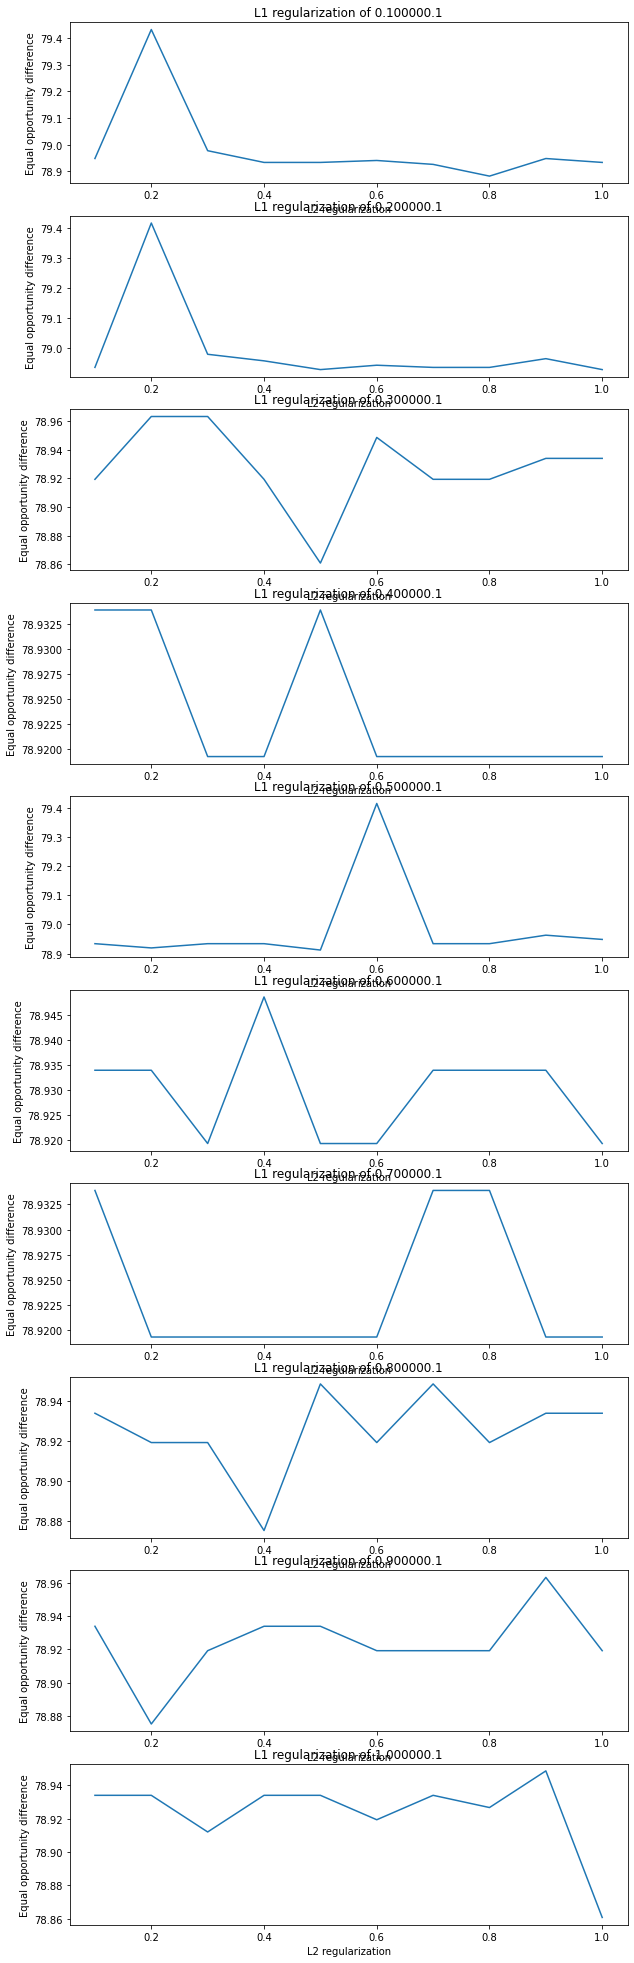

In [ ]:
reg_alpha_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
reg_lambda_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

fig, ax = plt.subplots(nrows = len(reg_alpha_range), ncols = 1, figsize = (10,35))

for i,c in enumerate(reg_alpha_range):
  acc_rw_reg = []
  for j,d in enumerate(reg_lambda_range):
    xgb_temp  = XGBClassifier(base_score= 0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0,learning_rate= 0.1, max_delta_step=0, max_depth= 5 ,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', 
       reg_alpha=c, reg_lambda=d,
       scale_pos_weight= 1 , seed=0, silent=True, subsample=1)
  
    _,temp_acc_rw,_,_ = cross_validation_result_w_reweighing(xgb_temp, 5, RW, X_train_adult, y_train_adult,train_adult,unprivileged_groups= unprivileged_groups, privileged_groups = privileged_groups)
    acc_rw_reg.append(temp_acc_rw)


  ax[i].plot(reg_lambda_range, acc_rw_reg)
  ax[i].set_ylabel("Accuracy")
  ax[i].set_xlabel("L2 regularization")
  ax[i].set_title(f"L1 regularization of %5f.1"%c)
plt.show()

Model 3

In [170]:
#Model with highest accuracy of l1 = 0.1, l2 = 0.2
Model_3 = XGBClassifier(base_score= 0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0,learning_rate= 0.025, max_delta_step=0, max_depth= 5 ,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', 

       reg_alpha=0.1, reg_lambda=0.2,

       scale_pos_weight= 0.8 , seed=0, silent=True, subsample=1)
  
n_train = RW.fit_transform(train_adult)

Model_3.fit(X_train_adult, y_train_adult, sample_weight=n_train.instance_weights)
predictions = Model_3.predict(X_test_adult)

test_adult_pred = test_adult.copy()
test_adult_pred.labels = predictions 

#Obtaining accuracy
test_acc_fairness = sum(predictions==y_test_adult)/len(y_test_adult)

#Obtaining eq_opp_diff
metric = ClassificationMetric(test_adult, test_adult_pred, unprivileged_groups= unprivileged_groups, privileged_groups=privileged_groups)
eq_opp_diff_test = metric.equal_opportunity_difference()

eq_opp_diff_test,test_acc_fairness

(0.022209175644595097, 0.8046816351600354)

Model 4

In [173]:
#Model with highest fairness metric of l1 = 0.1, l2 = 0.2
Model_4 = XGBClassifier(base_score= 0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0,learning_rate= 0.025, max_delta_step=0, max_depth= 5 ,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', 

       reg_alpha=0, reg_lambda=1.0,

       scale_pos_weight= 0.8 , seed=0, silent=True, subsample=1)
  
n_train = RW.fit_transform(train_adult)

Model_4.fit(X_train_adult, y_train_adult, sample_weight= n_train.instance_weights)
predictions = Model_4.predict(X_test_adult)

test_adult_pred = test_adult.copy()
test_adult_pred.labels = predictions 

#Obtaining accuracy
test_acc_fairness = sum(predictions==y_test_adult)/len(y_test_adult)

#Obtaining eq_opp_diff
metric = ClassificationMetric(test_adult, test_adult_pred, unprivileged_groups= unprivileged_groups, privileged_groups=privileged_groups)
eq_opp_diff_test = metric.equal_opportunity_difference()

eq_opp_diff_test,test_acc_fairness

(0.022209175644595097, 0.8046816351600354)

**Utilising Statistical parity difference as Model selection criterion:**

Without reweighing 

The average eq_opp_diff across 5 is -45.20255863539446
The average eq_opp_diff across 5 is -45.20255863539446
The average eq_opp_diff across 5 is -45.91329068941009
The average eq_opp_diff across 5 is -45.91329068941009
The average eq_opp_diff across 5 is -45.98436389481166
The average eq_opp_diff across 5 is -45.98436389481166
The average eq_opp_diff across 5 is -45.98436389481166


Text(0.5, 1.0, 'Statistical parity difference vs learning rate')

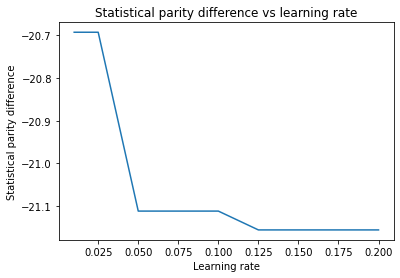

In [ ]:
learning_rate_l = [0.01,0.025,0.05,0.1,0.125,0.15,0.2]
stat_parr_diff_learning_rate = []

for l in learning_rate_l:  
  xgb_temp = XGBClassifier(base_score= 0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0,

       learning_rate= l, 

       max_delta_step=0, max_depth= 5 ,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1.0,

       scale_pos_weight= 1 , seed=0, silent=True, subsample=1)
  
  _,_,temp_stat_parr_diff = cross_validation_result_w_fairness(xgb_temp, 5, X_train_adult, y_train_adult,train_adult)
  stat_parr_diff_learning_rate.append(temp_stat_parr_diff)
  
plt.plot(learning_rate_l,stat_parr_diff_learning_rate)
plt.ylabel("Statistical parity difference")
plt.xlabel("Learning rate")
plt.title("Statistical parity difference vs learning rate")

The average eq_opp_diff across 5 is -45.20255863539446
The average eq_opp_diff across 5 is -45.20255863539446
The average eq_opp_diff across 5 is -45.20255863539446
The average eq_opp_diff across 5 is -45.20255863539446
The average eq_opp_diff across 5 is -45.20255863539446
The average eq_opp_diff across 5 is -45.20255863539446
The average eq_opp_diff across 5 is -45.20255863539446
The average eq_opp_diff across 5 is -45.20255863539446
The average eq_opp_diff across 5 is -45.20255863539446
The average eq_opp_diff across 5 is -45.20255863539446
The average eq_opp_diff across 5 is -45.20255863539446
The average eq_opp_diff across 5 is -45.20255863539446
The average eq_opp_diff across 5 is -45.20255863539446
The average eq_opp_diff across 5 is -45.20255863539446
The average eq_opp_diff across 5 is -45.20255863539446
The average eq_opp_diff across 5 is -45.20255863539446
The average eq_opp_diff across 5 is -45.20255863539446
The average eq_opp_diff across 5 is -45.20255863539446
The averag

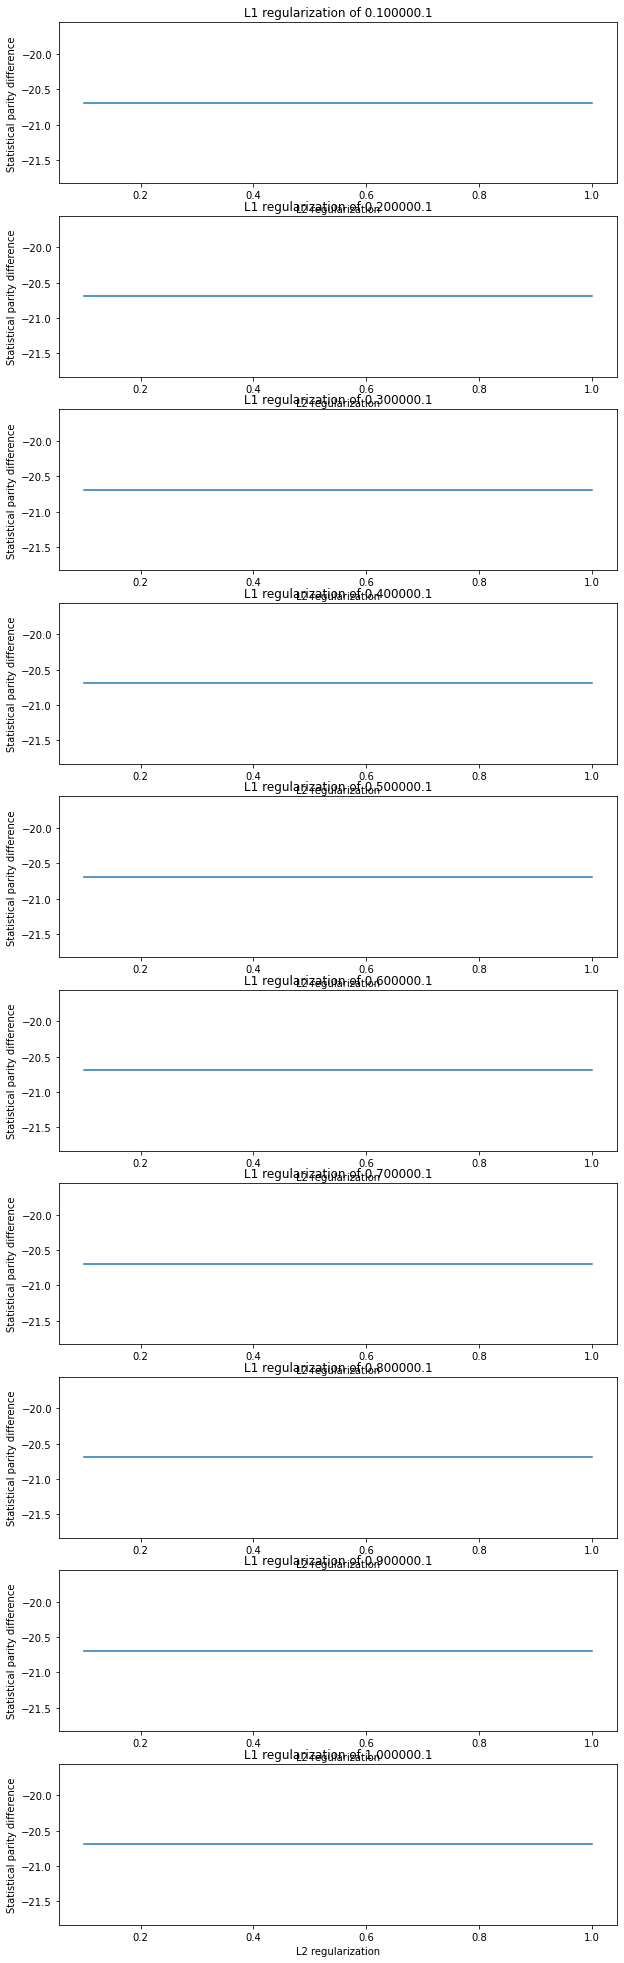

In [ ]:
reg_alpha_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
reg_lambda_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

fig, ax = plt.subplots(nrows = len(reg_alpha_range), ncols = 1, figsize = (10,35))

for i,c in enumerate(reg_alpha_range):
  stat_parr_diff_w_reg = []
  for j,d in enumerate(reg_lambda_range):
    xgb_temp  = XGBClassifier(base_score= 0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0,learning_rate= 0.025, max_delta_step=0, max_depth= 5 ,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', 
       reg_alpha=c, reg_lambda=d,
       scale_pos_weight= 1 , seed=0, silent=True, subsample=1)
  
    _,_,temp_stat_parr_diff = cross_validation_result_w_fairness(xgb_temp, 5, X_train_adult, y_train_adult,train_adult)
    stat_parr_diff_w_reg.append(temp_stat_parr_diff)


  ax[i].plot(reg_lambda_range,stat_parr_diff_w_reg)
  ax[i].set_ylabel("Statistical parity difference")
  ax[i].set_xlabel("L2 regularization")
  ax[i].set_title(f"L1 regularization of %5f.1"%c)

With reweighing

The average accuracy across 5 is 78.78034513015501,The average eq_opp_diff across 5 is -3.037895642683236
The average accuracy across 5 is 79.2921906990348,The average eq_opp_diff across 5 is 2.9970831307729706
The average accuracy across 5 is 78.79496928926586,The average eq_opp_diff across 5 is -3.037895642683236
The average accuracy across 5 is 79.29950277859024,The average eq_opp_diff across 5 is 2.9970831307729706
The average accuracy across 5 is 78.82421760748757,The average eq_opp_diff across 5 is -4.120928133657964
The average accuracy across 5 is 78.83152968704299,The average eq_opp_diff across 5 is 16.379436071949442
The average accuracy across 5 is 78.89733840304183,The average eq_opp_diff across 5 is -5.925982285282516
The average accuracy across 5 is 78.94121088037438,The average eq_opp_diff across 5 is 13.578026251823044
The average accuracy across 5 is 78.91196256215267,The average eq_opp_diff across 5 is -9.1750797582067
The average accuracy across 5 is 78.9631471190406

Text(0.5, 1.0, 'Reweighing: Statistical parity difference vs learning rate')

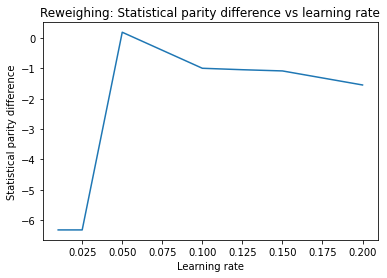

In [ ]:
learning_rate_l = [0.01,0.025,0.05,0.1,0.125,0.15,0.2]
stat_parr_diff_rw_learning_rate = []

for l in learning_rate_l:  
  xgb_temp = XGBClassifier(base_score= 0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0,

       learning_rate= l, 

       max_delta_step=0, max_depth= 5 ,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1.0,

       scale_pos_weight= 1 , seed=0, silent=True, subsample=1)
  
  _,_,_,temp_stat_parr_diff_rw = cross_validation_result_w_reweighing(xgb_temp, 5, RW, X_train_adult, y_train_adult,train_adult,unprivileged_groups= unprivileged_groups, privileged_groups = privileged_groups)
  stat_parr_diff_rw_learning_rate.append(temp_stat_parr_diff_rw)

plt.plot(learning_rate_l,stat_parr_diff_rw_learning_rate)
plt.ylabel("Statistical parity difference")
plt.xlabel("Learning rate")
plt.title("Reweighing: Statistical parity difference vs learning rate")

The average accuracy across 5 is 78.82421760748757,The average eq_opp_diff across 5 is -4.120928133657964
The average accuracy across 5 is 78.83152968704299,The average eq_opp_diff across 5 is 16.379436071949442
The average accuracy across 5 is 78.82421760748757,The average eq_opp_diff across 5 is -4.120928133657964
The average accuracy across 5 is 79.31412693770108,The average eq_opp_diff across 5 is 2.9970831307729706
The average accuracy across 5 is 78.82421760748757,The average eq_opp_diff across 5 is -4.120928133657964
The average accuracy across 5 is 78.83152968704299,The average eq_opp_diff across 5 is 16.379436071949442
The average accuracy across 5 is 78.82421760748757,The average eq_opp_diff across 5 is -4.120928133657964
The average accuracy across 5 is 78.83152968704299,The average eq_opp_diff across 5 is 16.379436071949442
The average accuracy across 5 is 78.82421760748757,The average eq_opp_diff across 5 is -4.120928133657964
The average accuracy across 5 is 78.8315296870

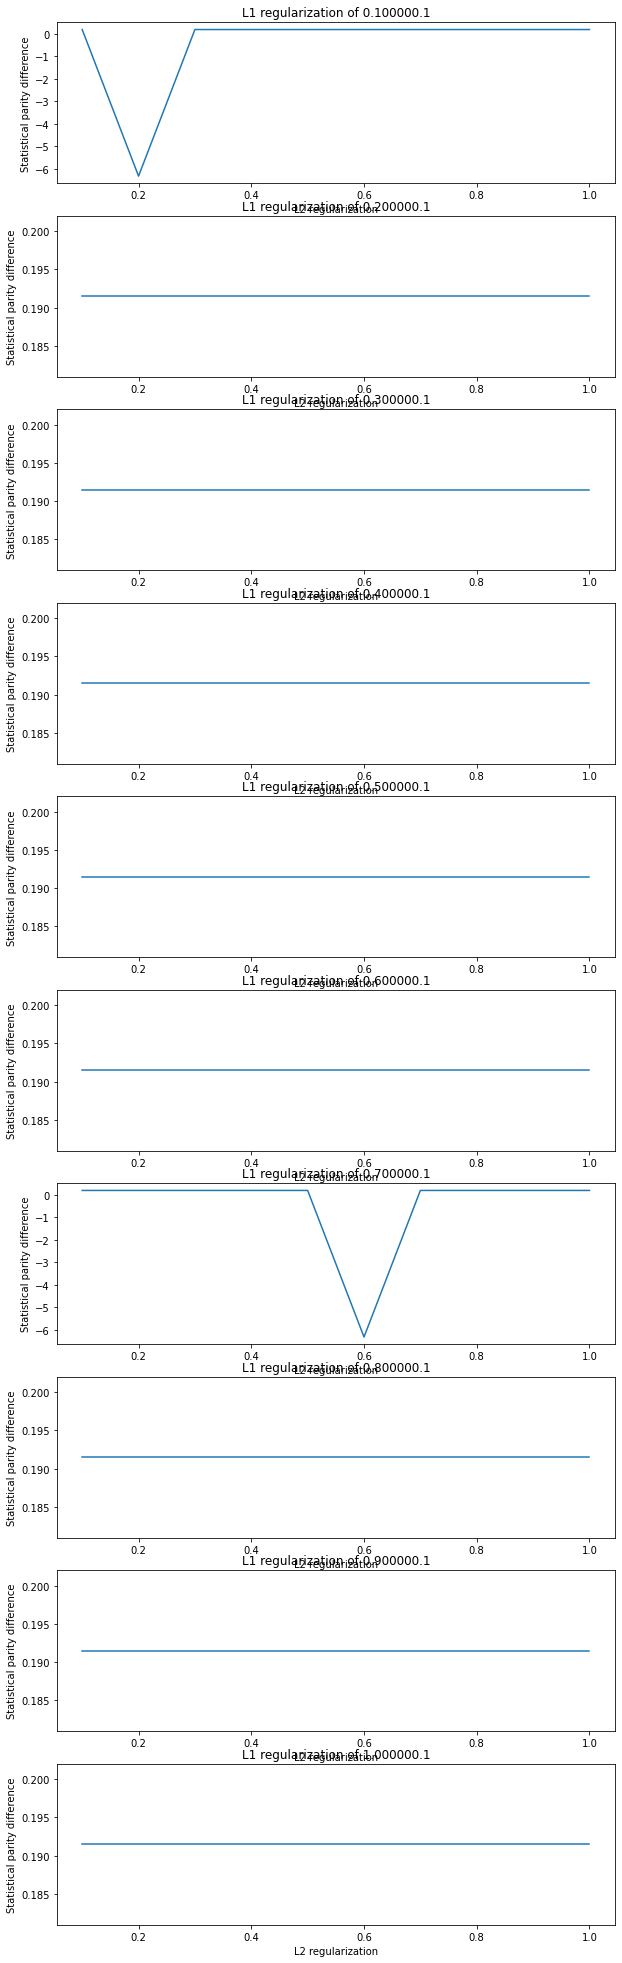

In [ ]:
reg_alpha_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
reg_lambda_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

fig, ax = plt.subplots(nrows = len(reg_alpha_range), ncols = 1, figsize = (10,35))

for i,c in enumerate(reg_alpha_range):
  stat_parr_diff_w_reg = []
  for j,d in enumerate(reg_lambda_range):
    xgb_temp  = XGBClassifier(base_score= 0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0,learning_rate= 0.05, max_delta_step=0, max_depth= 5 ,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', 
       reg_alpha=c, reg_lambda=d,
       scale_pos_weight= 1 , seed=0, silent=True, subsample=1)
  
    _,_,_,temp_stat_parr_diff_rw = cross_validation_result_w_reweighing(xgb_temp, 5, RW, X_train_adult, y_train_adult,train_adult,unprivileged_groups= unprivileged_groups, privileged_groups = privileged_groups)
    stat_parr_diff_w_reg.append(temp_stat_parr_diff_rw)


  ax[i].plot(reg_lambda_range,stat_parr_diff_w_reg)
  ax[i].set_ylabel("Statistical parity difference")
  ax[i].set_xlabel("L2 regularization")
  ax[i].set_title(f"L1 regularization of %5f.1"%c)

Model 5

In [ ]:
Model_5 = XGBClassifier(base_score= 0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0,

       learning_rate= 0.025, 

       max_delta_step=0, max_depth= 5 ,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0.1, reg_lambda=0.2,

       scale_pos_weight= 1 , seed=0, silent=True, subsample=1)

Model_5.fit(X_test_adult, y_test_adult)
predictions = Model_5.predict(X_test_adult)

test_adult_pred = test_adult.copy()
test_adult_pred.labels = predictions 

#Obtaining accuracy
test_acc_fairness = sum(predictions==y_test_adult)/len(y_test_adult)

#Obtaining eq_opp_diff
metric = ClassificationMetric(test_adult, test_adult_pred, unprivileged_groups= unprivileged_groups, privileged_groups=privileged_groups)
eq_opp_diff_test = metric.equal_opportunity_difference()

eq_opp_diff_test,test_acc_fairness

(-0.4377104377104377, 0.804886371391524)

Model 6

In [165]:
#With reweighing 
Model_6 = XGBClassifier(base_score= 0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0,

       learning_rate= 0.05, 

       max_delta_step=0, max_depth= 5 ,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0.1, reg_lambda=0.6,

       scale_pos_weight= 1, seed=0, silent=True, subsample=1)

n_train = RW.fit_transform(train_adult)

Model_6.fit(X_test_adult, y_test_adult, sample_weight=n_train.instance_weights)
predictions = Model_6.predict(X_test_adult)

test_adult_pred = test_adult.copy()
test_adult_pred.labels = predictions 

#Obtaining accuracy
test_acc_fairness = sum(predictions==y_test_adult)/len(y_test_adult)

#Obtaining eq_opp_diff
metric = ClassificationMetric(test_adult, test_adult_pred, unprivileged_groups= unprivileged_groups, privileged_groups=privileged_groups)
eq_opp_diff_test = metric.equal_opportunity_difference()

eq_opp_diff_test,test_acc_fairness

(0.02451398135818908, 0.8050228622125162)

In [193]:
cd /usr/local/lib/python3.7/dist-packages/aif360/data/raw/german

/usr/local/lib/python3.7/dist-packages/aif360/data/raw/german


In [156]:
#Downloading German Dataset 

!wget https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data
!wget	https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc

--2022-05-13 12:14:47--  https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79793 (78K) [application/x-httpd-php]
Saving to: ‘german.data.1’

german.data.1       100%[===================>]  77.92K  --.-KB/s    in 0.06s   

2022-05-13 12:14:47 (1.36 MB/s) - ‘german.data.1’ saved [79793/79793]

--2022-05-13 12:14:48--  https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4679 (4.6K) [application/x-httpd-php]
Saving to: ‘german.doc.1’

german.doc.1        100%[===================>]   4.57K  --.-KB/s    

In [200]:
#German Dataset 
privileged_groups = [{'age' : 1 }]
unprivileged_groups = [{'age':0 }]


dataset_german = load_preproc_data_german(['age'])
train_german, test_german = dataset_german.split([0.7], shuffle=True)
print("German training data size", train_german.features.shape)
print("German dataset feature names", train_german.feature_names)


German training data size (700, 11)
German dataset feature names ['age', 'sex', 'credit_history=Delay', 'credit_history=None/Paid', 'credit_history=Other', 'savings=500+', 'savings=<500', 'savings=Unknown/None', 'employment=1-4 years', 'employment=4+ years', 'employment=Unemployed']


In [199]:
#Normalize the dataset, both train and test
scale_orig = StandardScaler()

X_train_german = scale_orig.fit_transform(train_german.features)
y_train_german = train_german.labels.ravel()

X_test_german = scale_orig.fit_transform(test_german.features)
y_test_german = test_german.labels.ravel()

In [201]:
#Vary learning_rate, vary max_depth and also vary scale_pos_weight
import matplotlib.pyplot as plt


The average accuracy across 5 is 71.28571428571429
The average accuracy across 5 is 71.42857142857143
The average accuracy across 5 is 70.28571428571428
The average accuracy across 5 is 69.42857142857143
The average accuracy across 5 is 69.71428571428572
The average accuracy across 5 is 69.42857142857143
The average accuracy across 5 is 69.28571428571428


Text(0.5, 1.0, 'Accuracy vs learning rate')

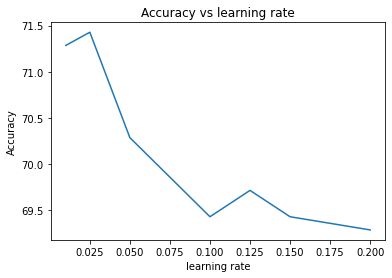

In [ ]:
learning_rate_l = [0.01,0.025,0.05,0.1,0.125,0.15,0.2]
accuracy_w_learning_rate = []

for l in learning_rate_l:
  xgb_temp  = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0,

      learning_rate= l, 

       max_delta_step=0, max_depth= 5 ,min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
  
  _,temp_avg = cross_validation_result(xgb_temp, 5, X_train_german,y_train_german, train_german)
  accuracy_w_learning_rate.append(temp_avg)

plt.plot(learning_rate_l,accuracy_w_learning_rate)

plt.ylabel("Accuracy")
plt.xlabel("learning rate")
plt.title("Accuracy vs learning rate")

The average accuracy across 5 is 71.42857142857143
The average accuracy across 5 is 71.00000000000001
The average accuracy across 5 is 71.14285714285715
The average accuracy across 5 is 71.42857142857143
The average accuracy across 5 is 71.42857142857143
The average accuracy across 5 is 71.42857142857143


Text(0.5, 1.0, 'Accuracy vs Scale_pos_weight')

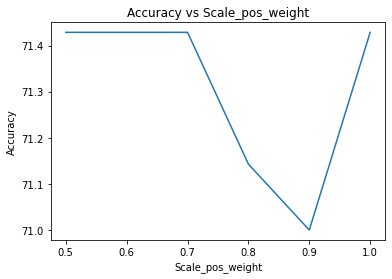

In [ ]:
accuracy_w_scale_pos_weight = []
scale_pos = [1,0.9,0.8,0.7,0.6,0.5]

for s in scale_pos:
  xgb_temp  = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0,learning_rate= 0.025, max_delta_step=0, max_depth= 5 ,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,

       scale_pos_weight= s, 
       
       seed=0, silent=True, subsample=1)
  
  _,temp_avg = cross_validation_result(xgb_temp,5, X_train_german,y_train_german, train_german)
  accuracy_w_scale_pos_weight.append(temp_avg)

plt.plot(scale_pos,accuracy_w_scale_pos_weight)

plt.ylabel("Accuracy")
plt.xlabel("Scale_pos_weight")
plt.title("Accuracy vs Scale_pos_weight")

Varying L1 regularization and L2 regularization

The average accuracy across 5 is 71.57142857142857
The average accuracy across 5 is 71.71428571428572
The average accuracy across 5 is 71.85714285714286
The average accuracy across 5 is 71.42857142857143
The average accuracy across 5 is 71.71428571428572
The average accuracy across 5 is 71.00000000000001
The average accuracy across 5 is 71.14285714285715
The average accuracy across 5 is 71.00000000000001
The average accuracy across 5 is 71.00000000000001
The average accuracy across 5 is 71.00000000000001
The average accuracy across 5 is 71.85714285714286
The average accuracy across 5 is 71.71428571428572
The average accuracy across 5 is 71.14285714285715
The average accuracy across 5 is 71.14285714285715
The average accuracy across 5 is 71.00000000000001
The average accuracy across 5 is 71.00000000000001
The average accuracy across 5 is 71.00000000000001
The average accuracy across 5 is 71.14285714285715
The average accuracy across 5 is 71.14285714285715
The average accuracy across 5 i

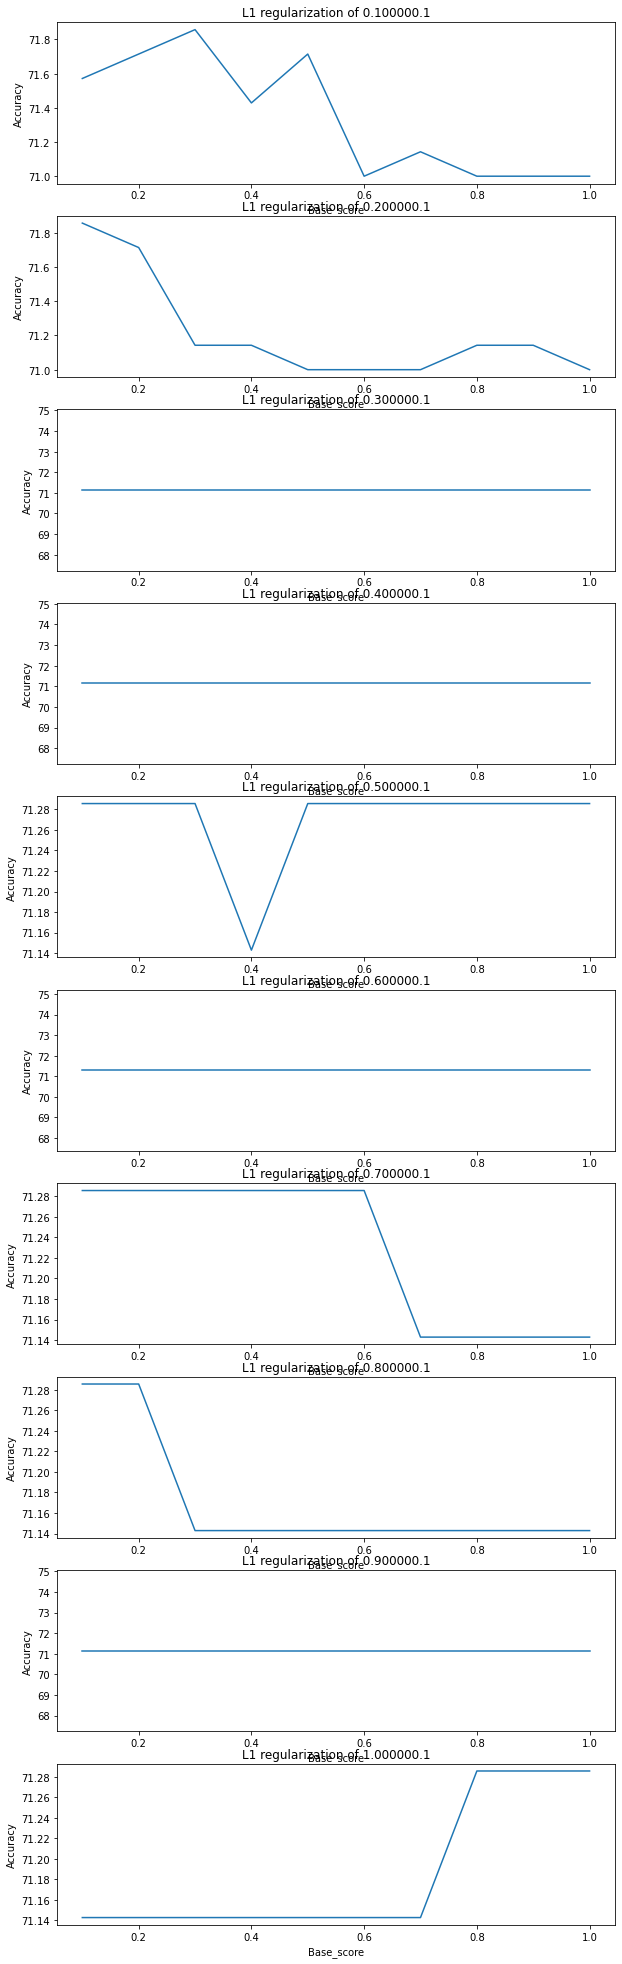

In [ ]:
reg_alpha_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
reg_lambda_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

fig, ax = plt.subplots(nrows = len(reg_alpha_range), ncols = 1, figsize = (10,35))

for i,c in enumerate(reg_alpha_range):
  accuracy_w_reg = []
  for j,d in enumerate(reg_lambda_range):
    xgb_temp  = XGBClassifier(base_score= 0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0,learning_rate= 0.025, max_delta_step=0, max_depth= 5 ,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', 
       reg_alpha=c, reg_lambda=d,
       scale_pos_weight= 1.0 , seed=0, silent=True, subsample=1)
  
    _,temp_avg, = cross_validation_result(xgb_temp, 5, X_train_german,y_train_german, train_german)
    accuracy_w_reg.append(temp_avg)

  ax[i].plot(reg_lambda_range,accuracy_w_reg)
  ax[i].set_ylabel("Accuracy")
  ax[i].set_xlabel("Base_score")
  ax[i].set_title(f"L1 regularization of %5f.1"%c)
plt.show()

In [202]:
#Highest accuracy was recorded with an L1 regularisation of 0.1, and L2 regularisation of 1.0 and learning rate of 0.025

german_model_1 = XGBClassifier(base_score= 0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0,learning_rate= 0.025, max_delta_step=0, max_depth= 5 ,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', 
       reg_alpha=0.1, reg_lambda=0.3,
       scale_pos_weight= 1, seed=0, silent=True, subsample=1)

german_model_1.fit(X_train_german, y_train_german)
predictions = german_model_1.predict(X_test_german)

#Obtaining accuracy
test_acc = sum(predictions==y_test_german)/len(y_test_german)
test_acc


test_german_pred = test_german.copy()
test_german_pred.labels = predictions 

#obtaining fairness metric
metric = ClassificationMetric(test_german, test_german_pred, unprivileged_groups= unprivileged_groups, privileged_groups=privileged_groups)
eq_opp_diff_test = metric.equal_opportunity_difference()

(eq_opp_diff_test,test_acc)

(0.027828191167574068, 0.7066666666666667)

ASSESSING FAIRNESS METRICS

The average eq_opp_diff across 5 is 0.0
The average eq_opp_diff across 5 is 0.0
The average eq_opp_diff across 5 is -1.1363636363636365
The average eq_opp_diff across 5 is -3.4090909090909087
The average eq_opp_diff across 5 is 3.7337662337662336
The average eq_opp_diff across 5 is 3.7337662337662336
The average eq_opp_diff across 5 is 3.7337662337662336


Text(0.5, 1.0, 'Equal opportunity difference vs Learning rate')

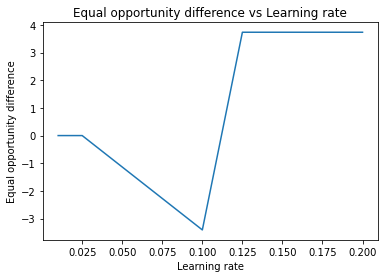

In [ ]:
#Starting with a max-depth of 5 and base score of 0.5

learning_rate = [0.01,0.025,0.05,0.1,0.125,0.15,0.2]
eq_opp_diff_w_learning_rate = [] 

for l in learning_rate:
  xgb_temp  = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, 
       learning_rate= l, 
       max_delta_step=0, max_depth= 5,min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=0.8, seed=0, silent=True, subsample=1)
  
  _,temp_eq_opp_diff,stat_parr_diff = cross_validation_result_w_fairness(xgb_temp, 5, X_train_german,y_train_german, train_german) 
  eq_opp_diff_w_learning_rate.append(temp_eq_opp_diff)

plt.plot(learning_rate, eq_opp_diff_w_learning_rate)
plt.ylabel("Equal opportunity difference")
plt.xlabel("Learning rate")
plt.title("Equal opportunity difference vs Learning rate")


The average accuracy across 5 is 69.71428571428572
The average accuracy across 5 is 69.71428571428572
The average accuracy across 5 is 69.42857142857143
The average accuracy across 5 is 69.57142857142857
The average accuracy across 5 is 69.85714285714286
The average accuracy across 5 is 69.71428571428572
The average accuracy across 5 is 69.71428571428572
The average accuracy across 5 is 69.57142857142857
The average accuracy across 5 is 69.14285714285715
The average accuracy across 5 is 69.71428571428572
The average accuracy across 5 is 69.85714285714286
The average accuracy across 5 is 69.57142857142857
The average accuracy across 5 is 69.85714285714286
The average accuracy across 5 is 69.57142857142857
The average accuracy across 5 is 69.57142857142857
The average accuracy across 5 is 69.57142857142857
The average accuracy across 5 is 69.57142857142857
The average accuracy across 5 is 70.0
The average accuracy across 5 is 70.0
The average accuracy across 5 is 70.14285714285714
The av

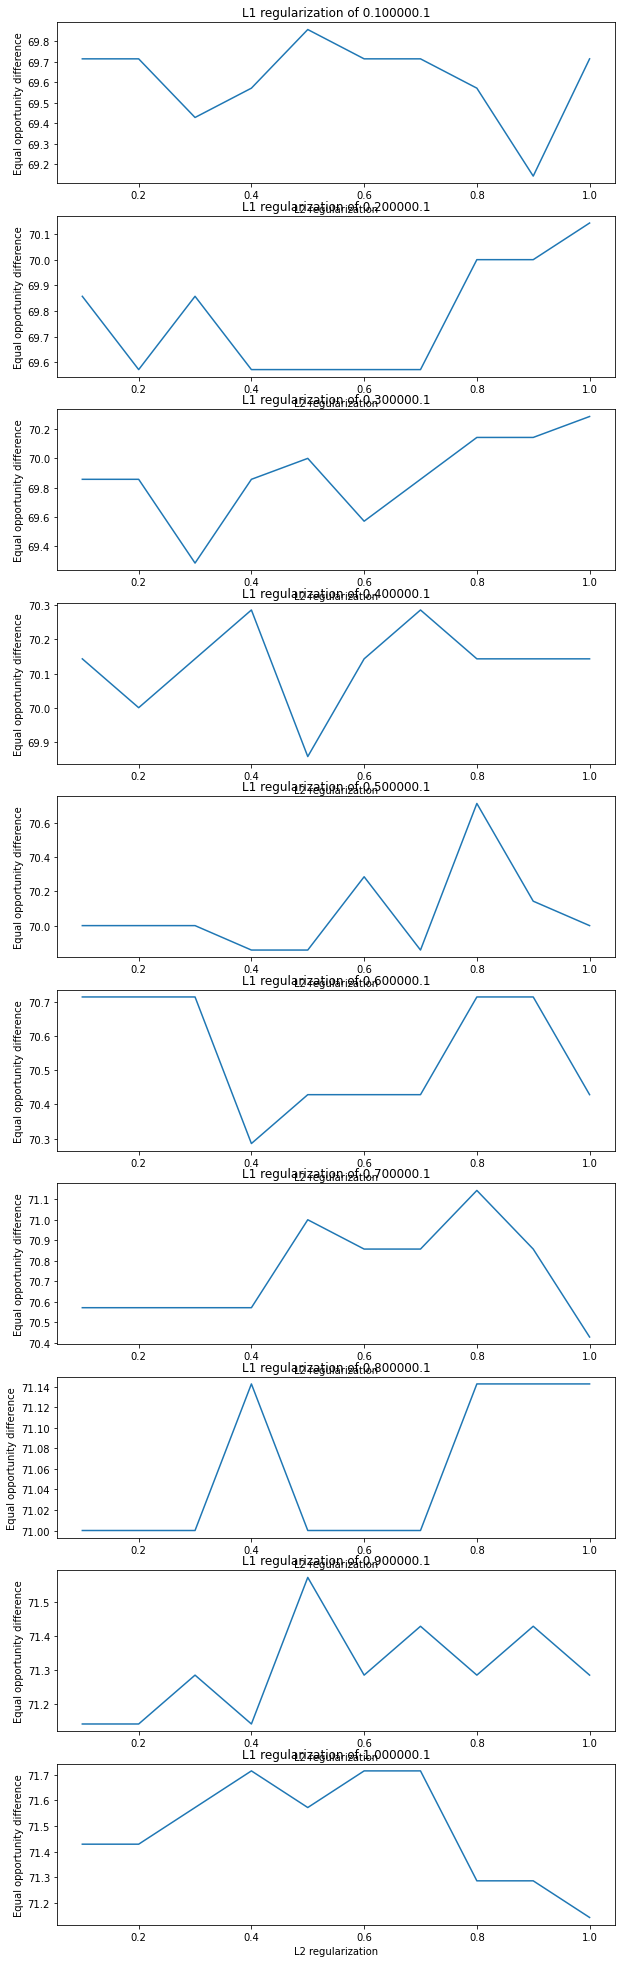

In [ ]:
reg_alpha_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
reg_lambda_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

fig, ax = plt.subplots(nrows = len(reg_alpha_range), ncols = 1, figsize = (10,35))

for i,c in enumerate(reg_alpha_range):
  eq_opp_diff_w_reg = []
  for j,d in enumerate(reg_lambda_range):
    xgb_temp  = XGBClassifier(base_score= 0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0,learning_rate= 0.125, max_delta_step=0, max_depth= 5 ,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', 
       reg_alpha=c, reg_lambda=d,
       scale_pos_weight= 1.0 , seed=0, silent=True, subsample=1)
  
    _,_, = cross_validation_result(xgb_temp, 5, X_train_german,y_train_german, train_german)
    eq_opp_diff_w_reg.append(temp_avg)

  ax[i].plot(reg_lambda_range,eq_opp_diff_w_reg)
  ax[i].set_ylabel("Equal opportunity difference")
  ax[i].set_xlabel("L2 regularization")
  ax[i].set_title(f"L1 regularization of %5f.1"%c)
plt.show()

Assessing Model on Test data

In [203]:
#Highest accuracy was recorded with an L1 regularisation of 0.1, and L2 regularisation of 1.0 and learning rate of 0.025

german_model_2 = XGBClassifier(base_score= 0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0,learning_rate= 0.125, max_delta_step=0, max_depth= 5 ,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', 
       reg_alpha=1, reg_lambda=0.4,
       scale_pos_weight= 1, seed=0, silent=True, subsample=1)
  
german_model_2.fit(X_train_german, y_train_german)
predictions = german_model_2.predict(X_test_german)

#Obtaining accuracy
test_acc = sum(predictions==y_test_german)/len(y_test_german)
test_acc


test_german_pred = test_german.copy()
test_german_pred.labels = predictions 

#obtaining fairness metric
metric = ClassificationMetric(test_german, test_german_pred, unprivileged_groups= unprivileged_groups, privileged_groups=privileged_groups)
eq_opp_diff_test = metric.equal_opportunity_difference()

(eq_opp_diff_test,test_acc)

(0.010586811857229206, 0.7033333333333334)

implementing reweighing

In [ ]:
#Starting with a max-depth of 5 and base score of 0.5
RW_b = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

xgb_rw = XGBClassifier(base_score= 0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0,learning_rate= 0.1, max_delta_step=0, max_depth= 5 ,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', 

       reg_alpha=0, reg_lambda=1.0,
       scale_pos_weight= 1 , seed=0, silent=True, subsample=1)

#Baseline for reweighing model
_,acc_rw,eq_opp_diff_rw,stat_parr_diff = cross_validation_result_w_reweighing(xgb_rw, 5, RW_b, X_train_german, y_train_german, train_german, unprivileged_groups= unprivileged_groups, privileged_groups = privileged_groups)
acc_rw,eq_opp_diff_rw,stat_parr_diff


The average accuracy across 5 is 63.57142857142857,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 67.5,The average eq_opp_diff across 5 is -3.7037037037037033


(67.5, -3.7037037037037033, -5.3097345132743365)

Varying hyperparameters

i) Accuracy

The average accuracy across 5 is 63.57142857142857,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 68.21428571428572,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 63.57142857142857,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 67.5,The average eq_opp_diff across 5 is -2.4691358024691357
The average accuracy across 5 is 63.57142857142857,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 67.5,The average eq_opp_diff across 5 is -2.4691358024691357
The average accuracy across 5 is 63.57142857142857,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 67.5,The average eq_opp_diff across 5 is -3.7037037037037033
The average accuracy across 5 is 63.57142857142857,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 67.5,The average eq_opp_diff across 5 is -3

Text(0.5, 1.0, 'Reweighing: Accuracy vs learning rate')

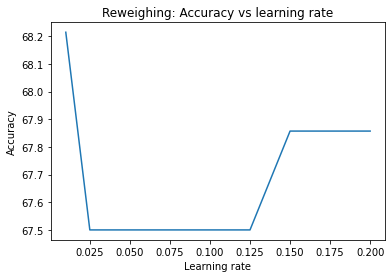

In [ ]:
learning_rate_l = [0.01,0.025,0.05,0.1,0.125,0.15,0.2]
acc_rw_learning_rate = []; eq_opp_diff_rw_learning_rate = []

for l in learning_rate_l:  
  xgb_temp = XGBClassifier(base_score= 0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0,

       learning_rate= l, 

       max_delta_step=0, max_depth= 5 ,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1.0,

       scale_pos_weight= 1 , seed=0, silent=True, subsample=1)
  
  _,temp_acc_rw,_,_ = cross_validation_result_w_reweighing(xgb_temp, 5, RW_b, X_train_german, y_train_german, train_german, unprivileged_groups= unprivileged_groups, privileged_groups = privileged_groups)
  acc_rw_learning_rate.append(temp_acc_rw)


plt.plot(learning_rate_l,acc_rw_learning_rate)
plt.ylabel("Accuracy")
plt.xlabel("Learning rate")
plt.title("Reweighing: Accuracy vs learning rate")

The average accuracy across 5 is 63.57142857142857,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 68.21428571428572,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 63.57142857142857,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 67.5,The average eq_opp_diff across 5 is -2.4691358024691357
The average accuracy across 5 is 63.57142857142857,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 67.5,The average eq_opp_diff across 5 is -2.4691358024691357
The average accuracy across 5 is 63.57142857142857,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 67.5,The average eq_opp_diff across 5 is -3.7037037037037033
The average accuracy across 5 is 63.57142857142857,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 67.5,The average eq_opp_diff across 5 is -3

Text(0.5, 1.0, 'Reweighing: Equal Opportunity difference vs learning rate')

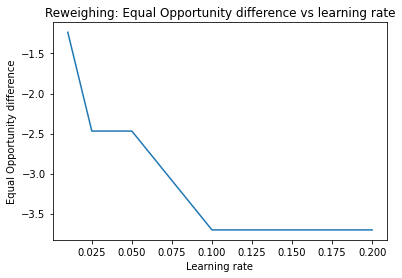

In [ ]:
learning_rate_l = [0.01,0.025,0.05,0.1,0.125,0.15,0.2]
eq_opp_diff_rw_learning_rate = []

for l in learning_rate_l:  
  xgb_temp = XGBClassifier(base_score= 0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0,

       learning_rate= l, 

       max_delta_step=0, max_depth= 5 ,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1.0,

       scale_pos_weight= 1 , seed=0, silent=True, subsample=1)
  
  _,_,temp_eq_opp_diff_rw,_ = cross_validation_result_w_reweighing(xgb_temp, 5, RW_b, X_train_german, y_train_german,train_german,unprivileged_groups= unprivileged_groups, privileged_groups = privileged_groups)
  eq_opp_diff_rw_learning_rate.append(temp_eq_opp_diff_rw)


plt.plot(learning_rate_l,eq_opp_diff_rw_learning_rate)
plt.ylabel("Equal Opportunity difference")
plt.xlabel("Learning rate")
plt.title("Reweighing: Equal Opportunity difference vs learning rate")

The average accuracy across 5 is 63.57142857142857,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 67.5,The average eq_opp_diff across 5 is -3.7037037037037033
The average accuracy across 5 is 63.57142857142857,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 67.5,The average eq_opp_diff across 5 is -3.7037037037037033
The average accuracy across 5 is 63.57142857142857,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 67.5,The average eq_opp_diff across 5 is -3.7037037037037033
The average accuracy across 5 is 63.57142857142857,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 67.5,The average eq_opp_diff across 5 is -3.7037037037037033
The average accuracy across 5 is 63.57142857142857,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 67.5,The average eq_opp_diff across 5 is -3.703703703703

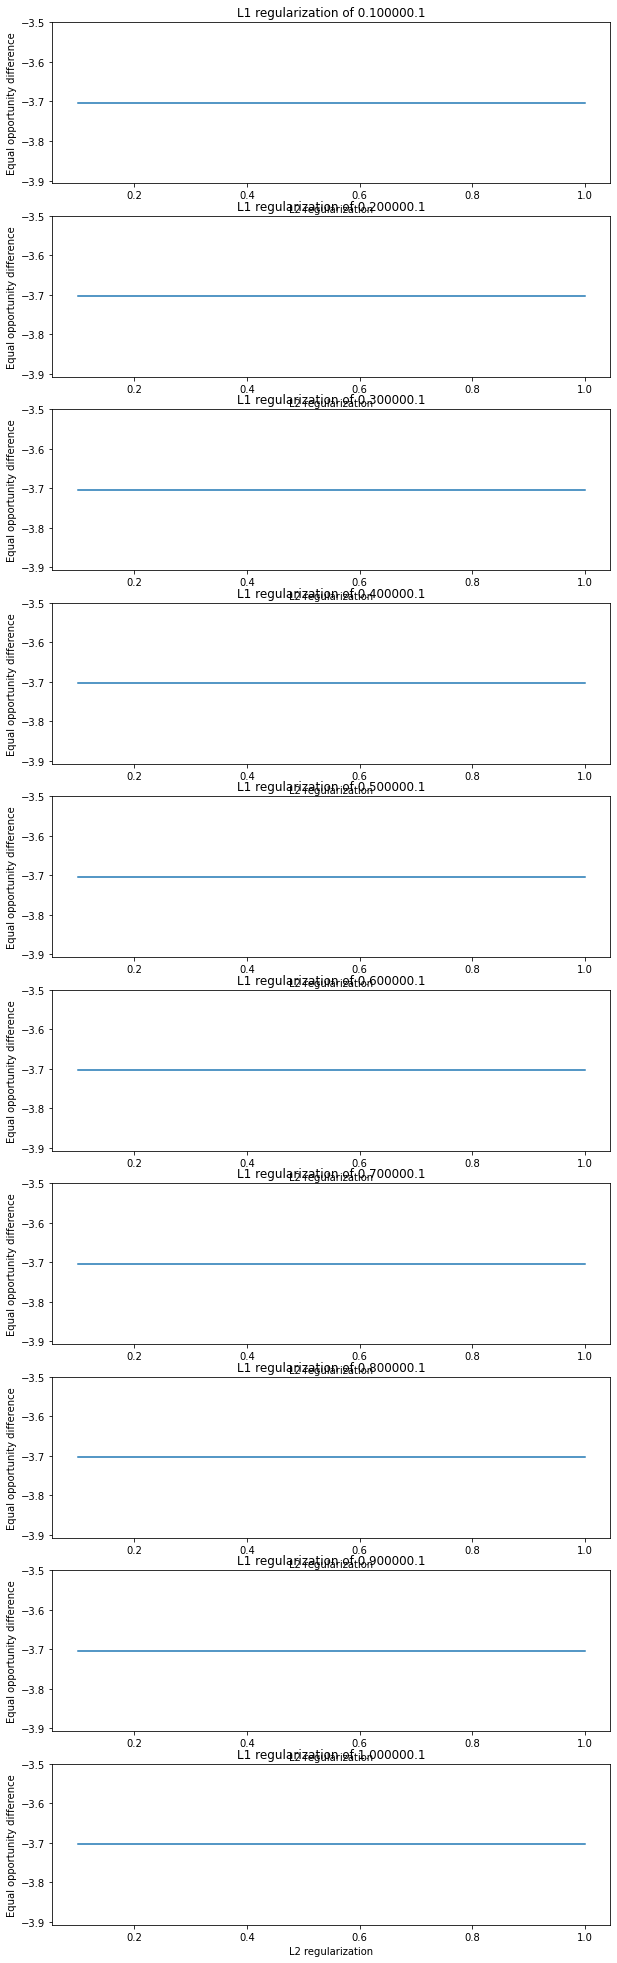

In [ ]:
reg_alpha_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
reg_lambda_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

fig, ax = plt.subplots(nrows = len(reg_alpha_range), ncols = 1, figsize = (10,35))

for i,c in enumerate(reg_alpha_range):
  eq_opp_diff_w_reg = []
  for j,d in enumerate(reg_lambda_range):
    xgb_temp  = XGBClassifier(base_score= 0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0,learning_rate= 0.01, max_delta_step=0, max_depth= 5 ,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', 
       reg_alpha=c, reg_lambda=d,
       scale_pos_weight= 1 , seed=0, silent=True, subsample=1)
  
    _,_,temp_eq_opp_diff_rw,_ = cross_validation_result_w_reweighing(xgb_rw, 5, RW_b, X_train_german, y_train_german, train_german, unprivileged_groups= unprivileged_groups, privileged_groups = privileged_groups)
    eq_opp_diff_w_reg.append(temp_eq_opp_diff_rw)


  ax[i].plot(reg_lambda_range,eq_opp_diff_w_reg)
  ax[i].set_ylabel("Equal opportunity difference")
  ax[i].set_xlabel("L2 regularization")
  ax[i].set_title(f"L1 regularization of %5f.1"%c)
plt.show()

The average accuracy across 5 is 63.57142857142857,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 67.85714285714286,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 63.57142857142857,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 67.85714285714286,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 63.57142857142857,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 68.21428571428572,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 63.57142857142857,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 68.21428571428572,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 63.57142857142857,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 67.5

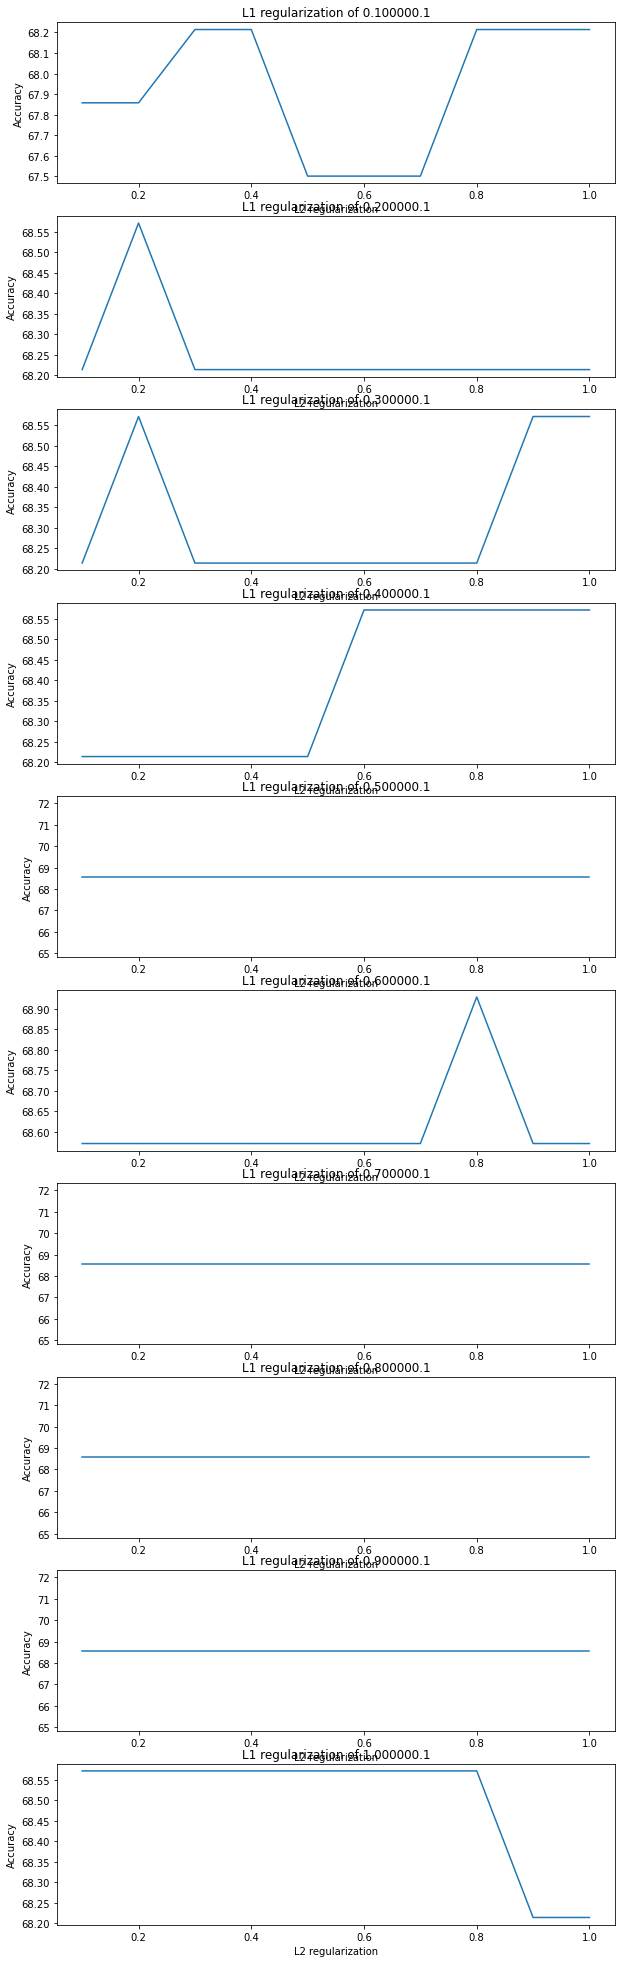

In [ ]:
reg_alpha_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
reg_lambda_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

fig, ax = plt.subplots(nrows = len(reg_alpha_range), ncols = 1, figsize = (10,35))

for i,c in enumerate(reg_alpha_range):
  acc_rw_reg = []
  for j,d in enumerate(reg_lambda_range):
    xgb_temp  = XGBClassifier(base_score= 0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0,learning_rate= 0.01, max_delta_step=0, max_depth= 5 ,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', 
       reg_alpha=c, reg_lambda=d,
       scale_pos_weight= 1 , seed=0, silent=True, subsample=1)
  
    _,temp_acc_rw,_,_ = cross_validation_result_w_reweighing(xgb_temp, 5, RW_b, X_train_german, y_train_german,train_german,unprivileged_groups= unprivileged_groups, privileged_groups = privileged_groups)
    acc_rw_reg.append(temp_acc_rw)


  ax[i].plot(reg_lambda_range, acc_rw_reg)
  ax[i].set_ylabel("Accuracy")
  ax[i].set_xlabel("L2 regularization")
  ax[i].set_title(f"L1 regularization of %5f.1"%c)
plt.show()

Model 3

In [204]:
#Model with highest accuracy of l1 = 0.6, l2 = 0.5
Model_3_german = XGBClassifier(base_score= 0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0,learning_rate= 0.01, max_delta_step=0, max_depth= 5 ,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', 

       reg_alpha=0.6, reg_lambda=0.8,

       scale_pos_weight= 0.8 , seed=0, silent=True, subsample=1)
  
n_train = RW_b.fit_transform(train_german)

Model_3_german.fit(X_train_german, y_train_german, sample_weight=n_train.instance_weights)
predictions = Model_3_german.predict(X_test_german)

test_german_pred = test_german.copy()
test_german_pred.labels = predictions 

#Obtaining accuracy
test_acc_fairness = sum(predictions==y_test_german)/len(y_test_german)

#Obtaining eq_opp_diff
metric = ClassificationMetric(test_german, test_german_pred, unprivileged_groups= unprivileged_groups, privileged_groups=privileged_groups)
eq_opp_diff_test = metric.equal_opportunity_difference()

eq_opp_diff_test,test_acc_fairness

(0.010586811857229206, 0.7)

Model 4

In [213]:
#Model with highest fairness metric, after reweighing, varying hyperparameters did not affect the output values
Model_4_german = XGBClassifier(base_score= 0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0,learning_rate= 0.01, max_delta_step=0, max_depth= 5 ,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', 

       reg_alpha=0, reg_lambda=1,

       scale_pos_weight= 0.8 , seed=0, silent=True, subsample=1)
  
n_train = RW_b.fit_transform(train_german)

Model_4_german.fit(X_train_german, y_train_german, sample_weight= n_train.instance_weights)
predictions = Model_4_german.predict(X_test_german)

test_german_pred = test_german.copy()
test_german_pred.labels = predictions 

#Obtaining accuracy
test_acc_fairness = sum(predictions==y_test_german)/len(y_test_german)

#Obtaining eq_opp_diff
metric = ClassificationMetric(test_german, test_german_pred, unprivileged_groups= unprivileged_groups, privileged_groups=privileged_groups)
eq_opp_diff_test = metric.equal_opportunity_difference()

eq_opp_diff_test,test_acc_fairness

(0.010586811857229206, 0.7033333333333334)

**Utilising Statistical parity difference as Model selection criterion:**

Without reweighing 

The average eq_opp_diff across 5 is 0.0
The average eq_opp_diff across 5 is 0.0
The average eq_opp_diff across 5 is 4.87012987012987
The average eq_opp_diff across 5 is 5.194805194805194
The average eq_opp_diff across 5 is -0.811688311688312
The average eq_opp_diff across 5 is 6.331168831168831
The average eq_opp_diff across 5 is 7.467532467532467


Text(0.5, 1.0, 'Statistical parity difference vs learning rate')

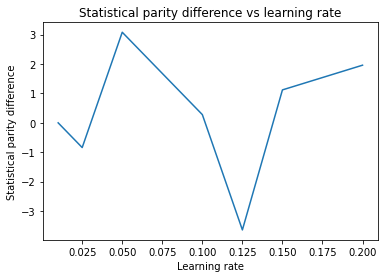

In [ ]:
learning_rate_l = [0.01,0.025,0.05,0.1,0.125,0.15,0.2]
stat_parr_diff_learning_rate = []

for l in learning_rate_l:  
  xgb_temp = XGBClassifier(base_score= 0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0,

       learning_rate= l, 

       max_delta_step=0, max_depth= 5 ,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1.0,

       scale_pos_weight= 1 , seed=0, silent=True, subsample=1)
  
  _,_,temp_stat_parr_diff = cross_validation_result_w_fairness(xgb_temp, 5, X_train_german, y_train_german, train_german)
  stat_parr_diff_learning_rate.append(temp_stat_parr_diff)
  
plt.plot(learning_rate_l,stat_parr_diff_learning_rate)
plt.ylabel("Statistical parity difference")
plt.xlabel("Learning rate")
plt.title("Statistical parity difference vs learning rate")

The average eq_opp_diff across 5 is -3.4090909090909087
The average eq_opp_diff across 5 is -3.4090909090909087
The average eq_opp_diff across 5 is -3.4090909090909087
The average eq_opp_diff across 5 is -3.4090909090909087
The average eq_opp_diff across 5 is -3.4090909090909087
The average eq_opp_diff across 5 is 0.0
The average eq_opp_diff across 5 is 0.0
The average eq_opp_diff across 5 is 0.0
The average eq_opp_diff across 5 is 0.0
The average eq_opp_diff across 5 is 0.0
The average eq_opp_diff across 5 is -3.4090909090909087
The average eq_opp_diff across 5 is -3.4090909090909087
The average eq_opp_diff across 5 is 0.0
The average eq_opp_diff across 5 is 0.0
The average eq_opp_diff across 5 is 0.0
The average eq_opp_diff across 5 is 0.0
The average eq_opp_diff across 5 is 0.0
The average eq_opp_diff across 5 is 0.0
The average eq_opp_diff across 5 is 0.0
The average eq_opp_diff across 5 is 0.0
The average eq_opp_diff across 5 is 0.0
The average eq_opp_diff across 5 is 0.0
The aver

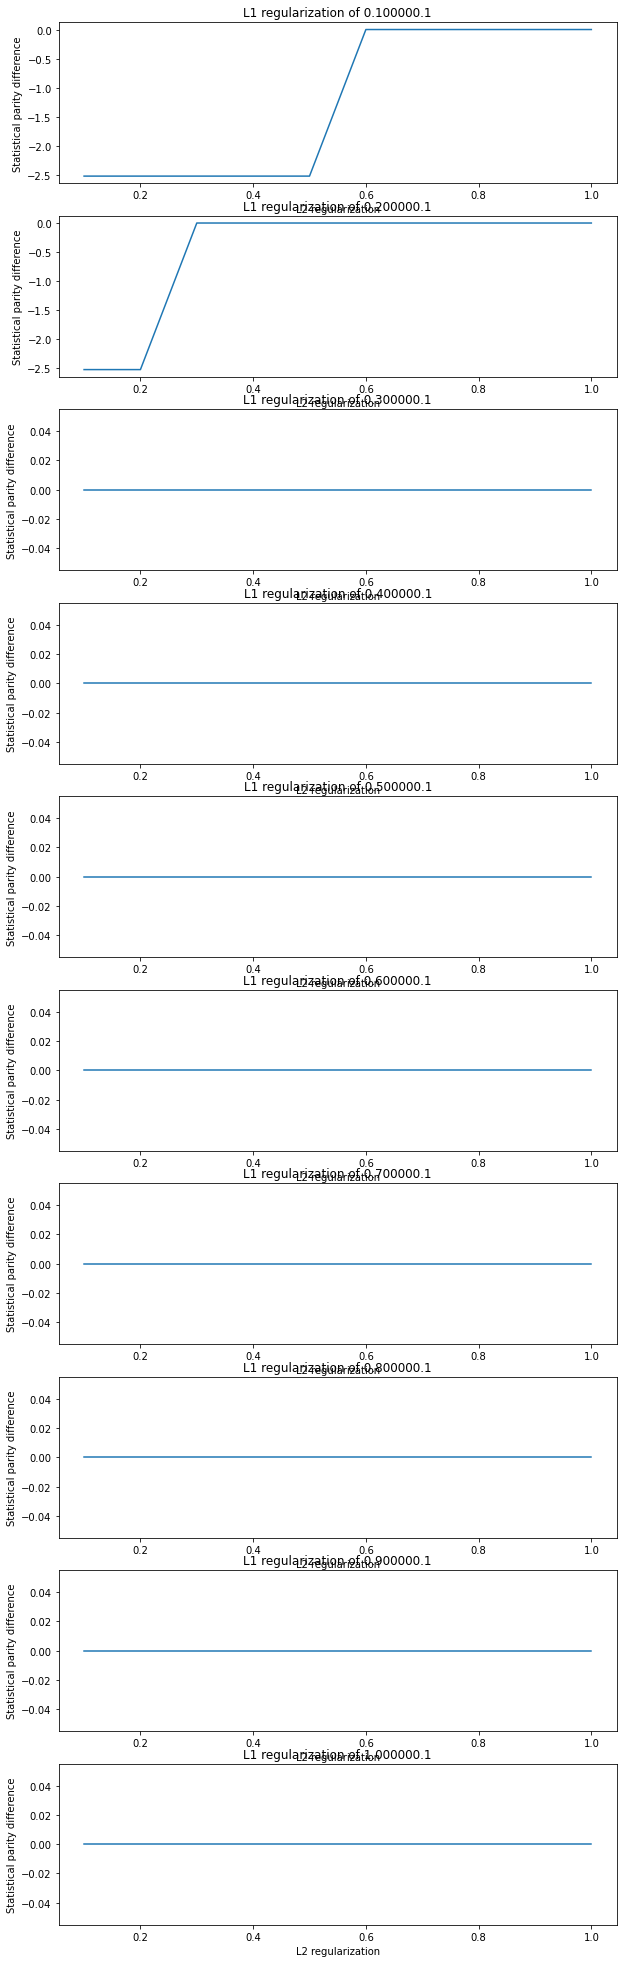

In [ ]:
reg_alpha_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
reg_lambda_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

fig, ax = plt.subplots(nrows = len(reg_alpha_range), ncols = 1, figsize = (10,35))

for i,c in enumerate(reg_alpha_range):
  stat_parr_diff_w_reg = []
  for j,d in enumerate(reg_lambda_range):
    xgb_temp  = XGBClassifier(base_score= 0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0,learning_rate= 0.01, max_delta_step=0, max_depth= 5 ,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', 
       reg_alpha=c, reg_lambda=d,
       scale_pos_weight= 1 , seed=0, silent=True, subsample=1)
  
    _,_,temp_stat_parr_diff = cross_validation_result_w_fairness(xgb_temp, 5, X_train_german, y_train_german, train_german)
    stat_parr_diff_w_reg.append(temp_stat_parr_diff)


  ax[i].plot(reg_lambda_range,stat_parr_diff_w_reg)
  ax[i].set_ylabel("Statistical parity difference")
  ax[i].set_xlabel("L2 regularization")
  ax[i].set_title(f"L1 regularization of %5f.1"%c)

With reweighing

The average accuracy across 5 is 63.57142857142857,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 68.21428571428572,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 63.57142857142857,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 67.5,The average eq_opp_diff across 5 is -2.4691358024691357
The average accuracy across 5 is 63.57142857142857,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 67.5,The average eq_opp_diff across 5 is -2.4691358024691357
The average accuracy across 5 is 63.57142857142857,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 67.5,The average eq_opp_diff across 5 is -3.7037037037037033
The average accuracy across 5 is 63.57142857142857,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 67.5,The average eq_opp_diff across 5 is -3

Text(0.5, 1.0, 'Reweighing: Statistical parity difference vs learning rate')

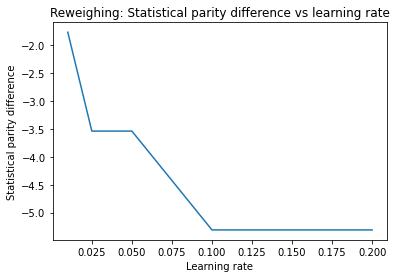

In [ ]:
learning_rate_l = [0.01,0.025,0.05,0.1,0.125,0.15,0.2]
stat_parr_diff_rw_learning_rate = []

for l in learning_rate_l:  
  xgb_temp = XGBClassifier(base_score= 0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0,

       learning_rate= l, 

       max_delta_step=0, max_depth= 5 ,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1.0,

       scale_pos_weight= 1 , seed=0, silent=True, subsample=1)
  
  _,_,_,temp_stat_parr_diff_rw = cross_validation_result_w_reweighing(xgb_temp, 5, RW_b, X_train_german, y_train_german,train_german,unprivileged_groups= unprivileged_groups, privileged_groups = privileged_groups)
  stat_parr_diff_rw_learning_rate.append(temp_stat_parr_diff_rw)

plt.plot(learning_rate_l,stat_parr_diff_rw_learning_rate)
plt.ylabel("Statistical parity difference")
plt.xlabel("Learning rate")
plt.title("Reweighing: Statistical parity difference vs learning rate")

The average accuracy across 5 is 63.57142857142857,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 67.85714285714286,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 63.57142857142857,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 67.85714285714286,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 63.57142857142857,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 68.21428571428572,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 63.57142857142857,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 68.21428571428572,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 63.57142857142857,The average eq_opp_diff across 5 is -1.2345679012345678
The average accuracy across 5 is 67.5

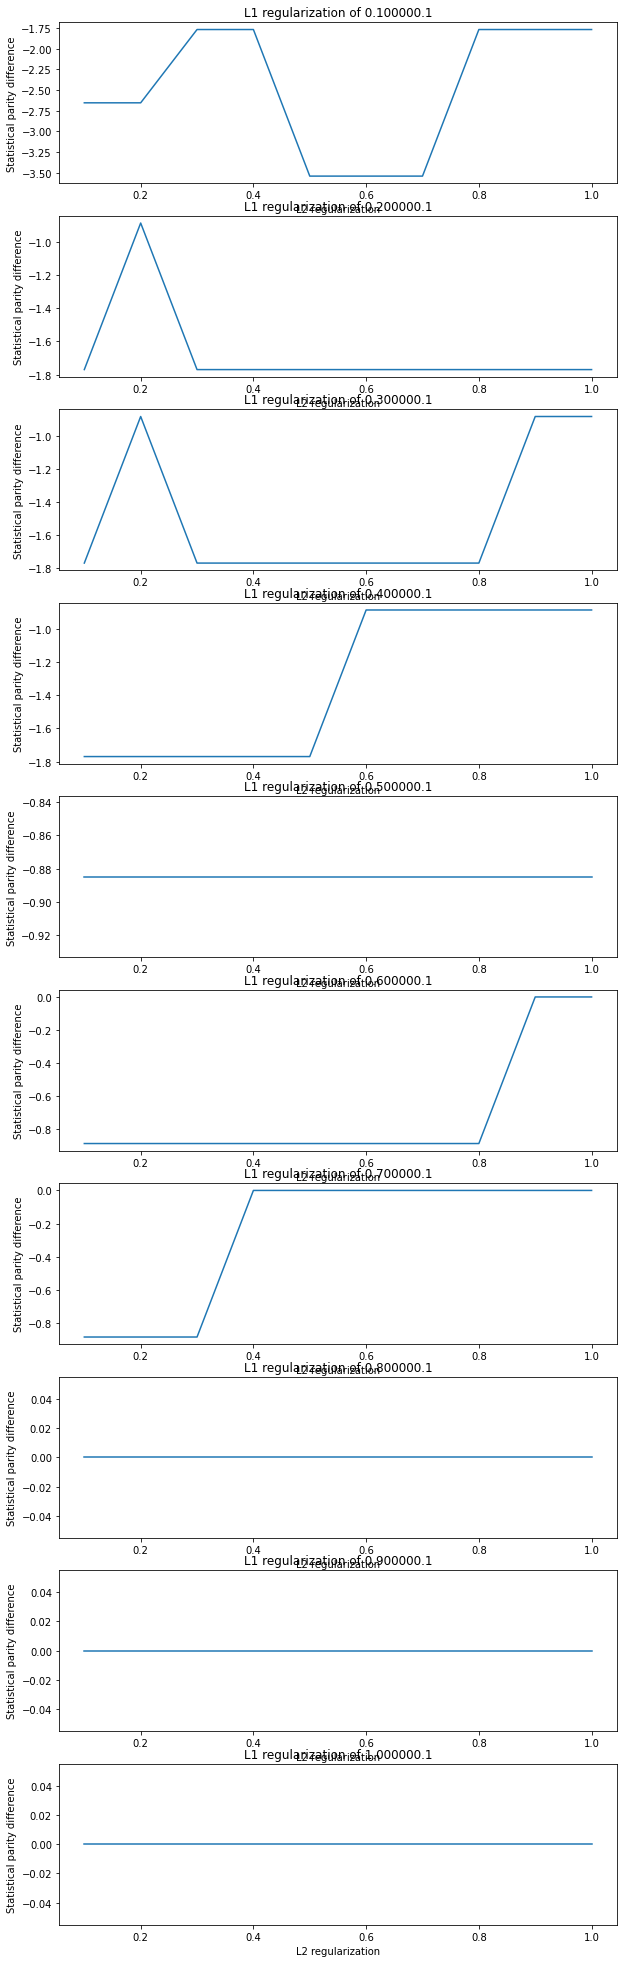

In [ ]:
reg_alpha_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
reg_lambda_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

fig, ax = plt.subplots(nrows = len(reg_alpha_range), ncols = 1, figsize = (10,35))

for i,c in enumerate(reg_alpha_range):
  stat_parr_diff_w_reg = []
  for j,d in enumerate(reg_lambda_range):
    xgb_temp  = XGBClassifier(base_score= 0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0,learning_rate= 0.01, max_delta_step=0, max_depth= 5 ,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', 
       reg_alpha=c, reg_lambda=d,
       scale_pos_weight= 1 , seed=0, silent=True, subsample=1)
  
    _,_,_,temp_stat_parr_diff_rw = cross_validation_result_w_reweighing(xgb_temp, 5, RW_b, X_train_german, y_train_german,train_german,unprivileged_groups= unprivileged_groups, privileged_groups = privileged_groups)
    stat_parr_diff_w_reg.append(temp_stat_parr_diff_rw)


  ax[i].plot(reg_lambda_range,stat_parr_diff_w_reg)
  ax[i].set_ylabel("Statistical parity difference")
  ax[i].set_xlabel("L2 regularization")
  ax[i].set_title(f"L1 regularization of %5f.1"%c)

Model 5

In [212]:
Model_5_german = XGBClassifier(base_score= 0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0,learning_rate= 0.01, max_delta_step=0, max_depth= 5 ,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', 

       reg_alpha=0.1, reg_lambda=0.6,

       scale_pos_weight= 0.8 , seed=0, silent=True, subsample=1)
  
Model_5_german.fit(X_train_german, y_train_german)
predictions = Model_5_german.predict(X_test_german)

test_german_pred = test_german.copy()
test_german_pred.labels = predictions 

#Obtaining accuracy
test_acc_fairness = sum(predictions==y_test_german)/len(y_test_german)

#Obtaining eq_opp_diff
metric = ClassificationMetric(test_german, test_german_pred, unprivileged_groups= unprivileged_groups, privileged_groups=privileged_groups)
eq_opp_diff_test = metric.equal_opportunity_difference()

eq_opp_diff_test,test_acc_fairness

(0.010586811857229206, 0.7033333333333334)

Model 6

In [161]:
Model_6_german = XGBClassifier(base_score= 0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0,learning_rate= 0.01, max_delta_step=0, max_depth= 5 ,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', 

       reg_alpha=0.6, reg_lambda=0.9,

       scale_pos_weight= 0.8 , seed=0, silent=True, subsample=1)

n_train = RW_b.fit_transform(train_german)

Model_6_german.fit(X_test_german, y_test_german, sample_weight=n_train.instance_weights)
predictions = Model_6_german.predict(X_test_german)

test_german_pred = test_german.copy()
test_german_pred.labels = predictions 

#Obtaining accuracy
test_acc_fairness = sum(predictions==y_test_german)/len(y_test_german)

#Obtaining eq_opp_diff
metric = ClassificationMetric(test_german, test_german_pred, unprivileged_groups= unprivileged_groups, privileged_groups=privileged_groups)
eq_opp_diff_test = metric.equal_opportunity_difference()

eq_opp_diff_test,test_acc_fairness

(0.0, 0.7133333333333334)

Fairness Through Unawareness

The concept of fairness through unawareness is examined on the german dataset by excluding the sensitive attribute which is sex

In [214]:
unaware_train = train_german.features[:,2:]
unaware_test = test_german.features[:,2:]

#Compute equal opportunity of difference with this
X_unaware_train_german = scale_orig.fit_transform(unaware_train)
y_train_german = train_german.labels.ravel()

X_unaware_test_german = scale_orig.fit_transform(unaware_test)
y_test_german = test_german.labels.ravel()

Baseline classifier

In [215]:
xgb_unaware = XGBClassifier()

xgb_unaware.fit(X_unaware_train_german, y_train_german)
predictions = xgb_unaware.predict(X_unaware_test_german)

test_german_pred = test_german.copy()
test_german_pred.labels = predictions 

#Obtaining accuracy
test_acc_fairness = sum(predictions==y_test_german)/len(y_test_german)

#Obtaining eq_opp_diff
metric = ClassificationMetric(test_german, test_german_pred, unprivileged_groups= unprivileged_groups, privileged_groups=privileged_groups)
eq_opp_diff_test = metric.equal_opportunity_difference()

eq_opp_diff_test,test_acc_fairness

(0.0, 0.7066666666666667)

In [216]:
german_model_1.fit(X_unaware_train_german, y_train_german)
predictions = german_model_1.predict(X_unaware_test_german)

test_german_pred = test_german.copy()
test_german_pred.labels = predictions 

#Obtaining accuracy
test_acc_fairness = sum(predictions==y_test_german)/len(y_test_german)

#Obtaining eq_opp_diff
metric = ClassificationMetric(test_german, test_german_pred, unprivileged_groups= unprivileged_groups, privileged_groups=privileged_groups)
eq_opp_diff_test = metric.equal_opportunity_difference()

eq_opp_diff_test,test_acc_fairness

(0.0, 0.7066666666666667)

In [217]:
german_model_2.fit(X_unaware_train_german, y_train_german)
predictions = german_model_2.predict(X_unaware_test_german)

test_german_pred = test_german.copy()
test_german_pred.labels = predictions 

#Obtaining accuracy
test_acc_fairness = sum(predictions==y_test_german)/len(y_test_german)

#Obtaining eq_opp_diff
metric = ClassificationMetric(test_german, test_german_pred, unprivileged_groups= unprivileged_groups, privileged_groups=privileged_groups)
eq_opp_diff_test = metric.equal_opportunity_difference()

eq_opp_diff_test,test_acc_fairness

(0.0, 0.7066666666666667)

In [218]:
Model_3_german.fit(X_unaware_train_german, y_train_german)
predictions = Model_3_german.predict(X_unaware_test_german)

test_german_pred = test_german.copy()
test_german_pred.labels = predictions 

#Obtaining accuracy
test_acc_fairness = sum(predictions==y_test_german)/len(y_test_german)

#Obtaining eq_opp_diff
metric = ClassificationMetric(test_german, test_german_pred, unprivileged_groups= unprivileged_groups, privileged_groups=privileged_groups)
eq_opp_diff_test = metric.equal_opportunity_difference()

eq_opp_diff_test,test_acc_fairness

(0.0, 0.7066666666666667)

In [219]:
Model_4_german.fit(X_unaware_train_german, y_train_german)
predictions = Model_4_german.predict(X_unaware_test_german)

test_german_pred = test_german.copy()
test_german_pred.labels = predictions 

#Obtaining accuracy
test_acc_fairness = sum(predictions==y_test_german)/len(y_test_german)

#Obtaining eq_opp_diff
metric = ClassificationMetric(test_german, test_german_pred, unprivileged_groups= unprivileged_groups, privileged_groups=privileged_groups)
eq_opp_diff_test = metric.equal_opportunity_difference()

eq_opp_diff_test,test_acc_fairness

(0.0, 0.7066666666666667)

In [220]:
Model_5_german.fit(X_unaware_train_german, y_train_german)
predictions = Model_5_german.predict(X_unaware_test_german)

test_german_pred = test_german.copy()
test_german_pred.labels = predictions 

#Obtaining accuracy
test_acc_fairness = sum(predictions==y_test_german)/len(y_test_german)

#Obtaining eq_opp_diff
metric = ClassificationMetric(test_german, test_german_pred, unprivileged_groups= unprivileged_groups, privileged_groups=privileged_groups)
eq_opp_diff_test = metric.equal_opportunity_difference()

eq_opp_diff_test,test_acc_fairness

(0.0, 0.7066666666666667)

In [221]:
Model_6_german.fit(X_unaware_train_german, y_train_german)
predictions = Model_6_german.predict(X_unaware_test_german)

test_german_pred = test_german.copy()
test_german_pred.labels = predictions 

#Obtaining accuracy
test_acc_fairness = sum(predictions==y_test_german)/len(y_test_german)

#Obtaining eq_opp_diff
metric = ClassificationMetric(test_german, test_german_pred, unprivileged_groups= unprivileged_groups, privileged_groups=privileged_groups)
eq_opp_diff_test = metric.equal_opportunity_difference()

eq_opp_diff_test,test_acc_fairness

(0.0, 0.7066666666666667)